In [ ]:
# Goal: Find an optimal business decision to create a popular stream game 
#       (more popular -> higher rating)
# e.g. 
# - Which category and genre should we include?
# - What languages and platforms should we support?
# - Should we require any ages?
# - Should we provide any discount?
# - Should we provide any website about the game?
# - How much should we set in price?
# - How long should we type on the short description?

# --- PART 1 ---
# Data Preprocessing
# - Check duplicate index gorup by 'Name' and 'Developer'
# - Missing data handling
# - Dropped irrelevant colums 'App ID', 'Name', 'Developer', 'Publisher', 'Header Image', 'Initial Price'
# - Dropped an outlier row with 'Type' != 'game'
# - Added an extra column - Release Month
# - Dropped 99 strange rows without Release Month
# - 'Short Description' -> changed to text length
# - 'Website' -> changed to whether there is a website url or not -> 0: no, 1: yes
# - [NOT USE - RESULT COLUMN]'Owners' -> changed to the mean of interval
# - [NOT USE - RESULT COLUMN]'Release Date' -> changed to the number of days before 2022-11-12 (+4) -> Checked 'Release Date' column is not normally distributed -> median
# - [NOT USE - RESULT COLUMN]'Tags' -> changed to total number of tags
# - 'Categories', 'Genre', 'Languages', 'Platforms' -> changed to multiple columns showing whether it's belong to those features
# - 'Discount' -> changed to whether there is a discount or not -> 0: no, 1: yes
# - 'Required Age' -> changed to whether it required age -> 0: no, 1: yes
# - Added an extra label - Rating -> Positive Reviews - Negative Review
# - Min-Max Normalization
# - [TODO] text analysis on columns 'Short Description' and 'Name'

# --- PART 2 ---
# Data Analysis and visualization
# - Heatmap -> Correlation betweeen any 2 features -> drop redundant columns
# - Boxplot
# - [NOT USE - DROP TOO MANY] Try dropping more outlier rows from boxplot to have a Parallel Coordinates Plot -> no obvious result found
# - T-test
# - [TODO] ANOVA, Chi-square test
# - [TODO] information gain for some columns
# - statistics for each columns, e.g. any normal distribution, mean, sd, ...
# - Assoication Rule Mining - Apriori Algorithm

# --- PART 3 ---
# Model Training
# - Splitting data into training and testing dataset
# - Reduce Columns by PCA -> find k
# - Model 1 - Decision Tree
# - Model 2 - Random Forest
# - Model 3 - SVM
# - Model 4 - K-NN
# - Model 5 - Multinomial Logistic Regression
# - Model 6 - LightGBM
# - Model 7 - XGBoost
# - Model 8 - Neural Networks
# - K-fold Cross-Validation
# - Insight from each models

# --- PART 4 ---
# Performance Tuning
# - Hyperparameter tuning - GridSearchCV for Decision Tree, Random Forest
# - [TODO] Hyperparameter tuning - SVM - Polynomial/Gaussian Kernel, e.g. svm.SVC(kernel='linear')
# - Ensemble modeling

# --- PART 5 ---
# Result
# - Accuracy comparison between models
# - Confusion-matrix
# - Classification metrices
# - ROC Curve
# - Comparison in model training and prediction process time between higher and lower dimension after PCA


In [1]:
# install libraries

import sys
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install mlxtend
!{sys.executable} -m pip install tabulate

# !{sys.executable} -m pip install nbconvert[webpdf]
# jupyter nbconvert --to webpdf --allow-chromium-download "COMP5152 - Project Code - Draft - v0.ipynb"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import libraries

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay, r2_score
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from pandas.plotting import parallel_coordinates
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn import svm
import scipy.stats as stats
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
import time
from sklearn.inspection import permutation_importance
from tabulate import tabulate

import mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns.association_rules import association_rules

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [351]:
# load dataset

df = pd.read_csv("steam_games.csv", sep = ';', header = 0)
df.shape

<ipython-input-351-ebdce9650fc6>:3: DtypeWarning:

Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.



(55691, 22)

In [352]:
# brief read the dataset

df.head(3)

App ID            Name                                  Short Description  \
0       10  Counter-Strike  Play the world's number 1 online action game. ...   
1  1000000       ASCENXION  ASCENXION is a 2D shoot 'em up game where you ...   
2  1000010     Crown Trick  Enter a labyrinth that moves as you move, wher...   

                Developer                 Publisher  \
0                   Valve                     Valve   
1  IndigoBlue Game Studio  PsychoFlux Entertainment   
2            NEXT Studios      Team17, NEXT Studios   

                             Genre  \
0                           Action   
1         Action, Adventure, Indie   
2  Adventure, Indie, RPG, Strategy   

                                                Tags  Type  \
0  Action: 5426, FPS: 4831, Multiplayer: 3392, Sh...  game   
1  "Shoot Em Up": 186, Metroidvania: 181, Bullet ...  game   
2  Rogue-like: 268, Turn-Based Combat: 254, RPG: ...  game   

                                          Categories  \
0  Multi-player, Valve Anti-Cheat enabled, Online...   
1  Single-player, Partial Controller Support, Ste...   
2  Single-player, Partial Controller Support, Ste...   

                     Owners  ...  Price  Initial Price  Discount    CCU  \
0  10,000,000 .. 20,000,000  ...    999            999         0  13990   
1               0 .. 20,000  ...    999            999         0      0   
2        200,000 .. 500,000  ...    599           1999        70     99   

                                           Languages            Platforms  \
0  English, French, German, Italian, Spanish - Sp...  windows, mac, linux   
1                English, Korean, Simplified Chinese              windows   
2  Simplified Chinese, English, Japanese, Traditi...              windows   

  Release Date Required Age Website  \
0    2000/11/1            0     NaN   
1   2021/05/14            0     NaN   
2   2020/10/16            0     NaN   

                                        Header Image  
0  https://cdn.akamai.steamstatic.com/steam/apps/...  
1  https://cdn.akamai.steamstatic.com/steam/apps/...  
2  https://cdn.akamai.steamstatic.com/steam/apps/...  

[3 rows x 22 columns]

In [353]:
# brief read the columns one by one

print(df.columns, '\n')

print(df['App ID'].value_counts(), '\n')
print(df['Name'].value_counts(), '\n')
print(df['Short Description'].value_counts(), '\n')
print(df['Developer'].value_counts(), '\n')
print(df['Publisher'].value_counts(), '\n')
print(df['Genre'].value_counts(), '\n')
print(df['Tags'].value_counts(), '\n')
print(df['Type'].value_counts(), '\n')
print(df['Categories'].value_counts(), '\n')
print(df['Owners'].value_counts(), '\n')
print(df['Positive Reviews'].value_counts(), '\n')
print(df['Negative Reviews'].value_counts(), '\n')
print(df['Price'].value_counts(), '\n')
print(df['Initial Price'].value_counts(), '\n')
print(df['Discount'].value_counts(), '\n')
print(df['CCU'].value_counts(), '\n')
print(df['Languages'].value_counts(), '\n')
print(df['Platforms'].value_counts(), '\n')
print(df['Release Date'].value_counts(), '\n')
print(df['Required Age'].value_counts(), '\n')
print(df['Website'].value_counts(), '\n')
print(df['Header Image'].value_counts(), '\n')

Index(['App ID', 'Name', 'Short Description', 'Developer', 'Publisher',
       'Genre', 'Tags', 'Type', 'Categories', 'Owners', 'Positive Reviews',
       'Negative Reviews', 'Price', 'Initial Price', 'Discount', 'CCU',
       'Languages', 'Platforms', 'Release Date', 'Required Age', 'Website',
       'Header Image'],
      dtype='object') 

10         1
493100     1
492720     1
492760     1
492800     1
          ..
1604640    1
1604700    1
1604710    1
1604780    1
999990     1
Name: App ID, Length: 55691, dtype: int64 

Alone                    5
Aurora                   4
Escape                   4
Dodge                    4
Lost                     4
                        ..
HuoChaiRenRPG            1
Hack Bomb BOMA-YE        1
Heltons Haunted Hotel    1
Unusual Findings         1
Bouncing Hero            1
Name: Name, Length: 55430, dtype: int64 

Find the objects that are hidden on the map.                                                                                      

In [354]:
# check any missing data

df.isna().sum()

App ID                   0
Name                     0
Short Description       37
Developer              129
Publisher              151
Genre                  161
Tags                   135
Type                     0
Categories             970
Owners                   0
Positive Reviews         0
Negative Reviews         0
Price                    0
Initial Price            0
Discount                 0
CCU                      0
Languages               11
Platforms                0
Release Date            99
Required Age             0
Website              25217
Header Image             0
dtype: int64

In [355]:
# copy dataframe

df_updated = df.copy()

In [356]:
# Check duplicate index gorup by 'Name' and 'Developer'

df_duplicated = df_updated[df_updated.duplicated(subset=['Name','Developer'], keep=False)]
len(df_duplicated.index)

0

In [357]:
# handling on missing data

df_updated["Short Description"] = np.where(df["Short Description"].isnull(), '', df["Short Description"])
df_updated["Developer"] = np.where(df["Developer"].isnull(), 'N/A', df["Developer"])
df_updated["Publisher"] = np.where(df["Publisher"].isnull(), 'N/A', df["Publisher"])
df_updated["Genre"] = np.where(df["Genre"].isnull(), '', df["Genre"])
df_updated["Tags"] = np.where(df["Tags"].isnull(), '', df["Tags"])
df_updated["Categories"] = np.where(df["Categories"].isnull(), '', df["Categories"])
df_updated["Languages"] = np.where(df["Languages"].isnull(), '', df["Languages"])
df_updated["Website"] = np.where(df["Website"].isnull(), 0, 1)

In [358]:
# handling on Short Description -> length (we don't use how many number of words since there may be other languages)

df_updated["Short Description"] = df_updated['Short Description'].apply(lambda x: len(x))

In [359]:
# add an extra column - Release Month

df_updated["Release Month"] = df['Release Date'].apply(lambda x: (str(x) + "/").replace(r'-', '/').split("/")[1])
df_updated["Release Month"] = np.where(df_updated["Release Month"] == '', 0, df_updated["Release Month"])
df_updated["Release Month"] = df_updated['Release Month'].apply(lambda x: int(x))
df_updated['Release Month'].value_counts()

10    5549
9     5177
8     5077
7     4767
5     4731
3     4708
11    4557
4     4470
12    4248
2     4219
6     4212
1     3877
0       99
Name: Release Month, dtype: int64

In [360]:
# add an extra column - Release Year

df_updated['Release Date'] = pd.to_datetime(df['Release Date'])
df_updated['Release Year'] = df_updated['Release Date'].dt.year
df_updated['Release Year'] = df_updated['Release Year'].replace('nan', 'N/A')
# df_updated = df_updated.dropna(subset=['Year'])
# df_updated['Year'] = df_updated['Year'].astype(np.int64)
print(df_updated["Release Year"].value_counts().sort_index(), '\n')
print(df_updated.shape)
# df_2018_2022_updated = df_2018_2022_updated[df_2018_2022_updated['Year'].isin([2018, 2019, 2020, 2021, 2022])].dropna(subset=['Genre','Year'])

1997.0       2
1998.0       1
1999.0       3
2000.0       2
2001.0       4
2002.0       1
2003.0       3
2004.0       6
2005.0       6
2006.0      61
2007.0      98
2008.0     159
2009.0     311
2010.0     288
2011.0     267
2012.0     345
2013.0     471
2014.0    1557
2015.0    2576
2016.0    4185
2017.0    6017
2018.0    7678
2019.0    6968
2020.0    8305
2021.0    8823
2022.0    7455
Name: Release Year, dtype: int64 

(55691, 24)


1207    116
1030     74
43       64
758      63
408      62
       ... 
4347      1
4246      1
5834      1
3455      1
4385      1
Name: Release Date, Length: 3944, dtype: int64

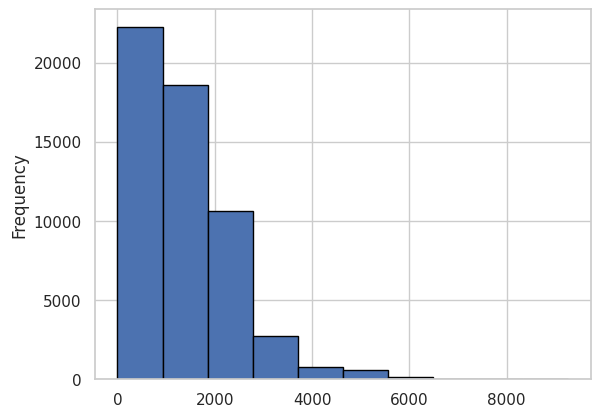

In [361]:
# [NOT USE] handling on Release Date -> number of days before 2022-11-12 (+4)

df_updated["Release Date"] = df['Release Date'].apply(lambda x: (pd.to_datetime("2022-11-12") - pd.to_datetime(x)).total_seconds() / 60 / 60 / 24)

df_updated['Release Date'].plot(kind='hist', edgecolor='black')
median_days = int(df_updated["Release Date"].median(skipna=True))

df_updated["Release Date"] = np.where(df_updated["Release Date"].isnull(), median_days, df_updated["Release Date"])
df_updated["Release Date"] = df_updated["Release Date"].apply(int)

df_updated['Release Date'].value_counts()

In [362]:
# check missing data again
df_updated.isna().sum()

App ID                0
Name                  0
Short Description     0
Developer             0
Publisher             0
Genre                 0
Tags                  0
Type                  0
Categories            0
Owners                0
Positive Reviews      0
Negative Reviews      0
Price                 0
Initial Price         0
Discount              0
CCU                   0
Languages             0
Platforms             0
Release Date          0
Required Age          0
Website               0
Header Image          0
Release Month         0
Release Year         99
dtype: int64

In [363]:
print(df_updated.shape)

(55691, 24)


In [364]:
# [NOT USE] handling on Owner -> average of interval

df_updated["Owners"] = df_updated["Owners"].apply(lambda x: (int(x.replace(r',', '').split(" .. ")[1]) 
                                                             - int(x.replace(r',', '').split(" .. ")[0])) 
                                                  / 2)
df_updated['Owners'].value_counts()

10000.0        38072
15000.0         7285
25000.0         3695
50000.0         2519
150000.0        2162
250000.0         933
500000.0         526
1500000.0        335
2500000.0         97
5000000.0         41
15000000.0        21
25000000.0         4
150000000.0        1
Name: Owners, dtype: int64

In [365]:
# [NOT USE] handling on Tags -> total number of tags

df_updated['Tags'] = df_updated['Tags'].apply(
    lambda x: sum(
        [
            int(y.split(':')[1]) 
             for y in x.replace(r' ', '').split(',') 
             if len(y.split(':')) == 2
        ]
    )
)

df_updated['Tags'].value_counts()

63      506
42      473
62      304
84      263
48      260
       ... 
7141      1
5323      1
7861      1
5057      1
4022      1
Name: Tags, Length: 6921, dtype: int64

In [366]:
df_platform_updated = df_updated
print(df_platform_updated.shape)

(55691, 24)


In [367]:
df_platform_updated.head(1)

App ID            Name  Short Description Developer Publisher   Genre  \
0      10  Counter-Strike                315     Valve     Valve  Action   

    Tags  Type                                         Categories     Owners  \
0  32804  game  Multi-player, Valve Anti-Cheat enabled, Online...  5000000.0   

   ...  Discount    CCU                                          Languages  \
0  ...         0  13990  English, French, German, Italian, Spanish - Sp...   

             Platforms  Release Date  Required Age Website  \
0  windows, mac, linux          8046             0       0   

                                        Header Image  Release Month  \
0  https://cdn.akamai.steamstatic.com/steam/apps/...             11   

  Release Year  
0       2000.0  

[1 rows x 24 columns]

In [368]:
# handling on columns - Categories, Genre, Type, Languages, Platforms -> multiple columns

platform_column_names = ['Platforms']

for name in platform_column_names:
    # transform the column values from <column_name> to multiple columns
    sub_df = df[name].str.replace(r' ', '', regex=True) \
            .replace(r'\r\n', '', regex=True) \
            .replace(r'[b]*[/b]', '', regex=True) \
            .replace(r'[]*[]', '', regex=True) \
            .str.get_dummies(sep=',')
    sub_df = sub_df.add_suffix('_' + name)
    

    # filter the new category columns if greater than customized usage percentage (>= 0.5%)
    # series = (sub_df.sum() / sub_df.shape[0] * 100).loc[lambda x : (x >= 0.5) & (x <= 99.5)].sort_values(ascending=False)
    series = (sub_df.sum() / sub_df.shape[0] * 100).sort_values(ascending=False)
    # print(series, '\n')

    # append the new category columns to df
    df_platform_updated = df_platform_updated.join(sub_df[pd.DataFrame(series).transpose().columns])


In [369]:
# handling on columns - Categories, Genre, Type, Languages, Platforms -> multiple columns

column_names = ['Categories', 'Genre', 'Languages', 'Platforms']

for name in column_names:
    # transform the column values from <column_name> to multiple columns
    sub_df = df[name].str.replace(r' ', '', regex=True) \
            .replace(r'\r\n', '', regex=True) \
            .replace(r'[b]*[/b]', '', regex=True) \
            .replace(r'[]*[]', '', regex=True) \
            .str.get_dummies(sep=',')
    sub_df = sub_df.add_suffix('_' + name)
    

    # filter the new category columns if greater than customized usage percentage (>= 0.5%)
    series = (sub_df.sum() / sub_df.shape[0] * 100).loc[lambda x : (x >= 0.5) & (x <= 99.5)].sort_values(ascending=False)
    print(series, '\n')

    # append the new category columns to df
    df_updated = df_updated.join(sub_df[pd.DataFrame(series).transpose().columns])


Single-player_Categories                93.417249
SteamAchievements_Categories            49.189277
SteamCloud_Categories                   25.560683
Fullcontrollersupport_Categories        21.330197
Multi-player_Categories                 20.568853
SteamTradingCards_Categories            16.534090
PartialControllerSupport_Categories     14.126160
PvP_Categories                          12.695049
Co-op_Categories                        10.084215
SteamLeaderoards_Categories              9.892083
OnlinePvP_Categories                     9.023002
RemotePlayTogether_Categories            8.726724
SharedSplitScreen_Categories             7.764271
SharedSplitScreenPvP_Categories          5.611320
OnlineCo-op_Categories                   5.352750
Stats_Categories                         5.253991
SharedSplitScreenCo-op_Categories        4.399275
RemotePlayonTV_Categories                3.485303
Cross-PlatformMultiplayer_Categories     3.127974
Includesleveleditor_Categories           2.975346


In [370]:
# handling on Required Age - true or false

df_updated['Required Age'] = df['Required Age'].apply(str).str.replace('+','').str.replace('MA','').str.replace(' ','').apply(int)
df_updated["Required Age"] = np.where(df_updated["Required Age"] == 0, 0, 1)
df_updated['Required Age'].value_counts()

<ipython-input-370-5f2be397579a>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



0    55030
1      661
Name: Required Age, dtype: int64

In [371]:
# handling on Required Age - true or false

df_platform_updated['Required Age'] = df['Required Age'].apply(str).str.replace('+','').str.replace('MA','').str.replace(' ','').apply(int)
df_platform_updated["Required Age"] = np.where(df_platform_updated["Required Age"] == 0, 0, 1)
df_platform_updated['Required Age'].value_counts()

<ipython-input-371-f4fec6cd50b2>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



0    55030
1      661
Name: Required Age, dtype: int64

In [372]:
# handling on Discount - true or false

df_updated['Discount'] = df['Discount'].apply(int)
df_updated["Discount"] = np.where(df_updated["Discount"] == 0, 0, 1)
df_updated['Discount'].value_counts()

0    53173
1     2518
Name: Discount, dtype: int64

In [373]:
# handling on Discount - true or false

df_platform_updated['Discount'] = df['Discount'].apply(int)
df_platform_updated["Discount"] = np.where(df_platform_updated["Discount"] == 0, 0, 1)
df_platform_updated['Discount'].value_counts()

0    53173
1     2518
Name: Discount, dtype: int64

In [374]:
# handling on label column from Positive Reviews, Negative Reviews

df_updated['Rating'] = df_updated['Positive Reviews'] - df_updated['Negative Reviews']

Q1 = df_updated["Rating"].quantile(0.25)
Q2 = df_updated["Rating"].quantile(0.5)
Q3 = df_updated["Rating"].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)
print(Lower_Fence, Q1, Q2, Q3, Upper_Fence)

# 4 classes, since no data is below `Lower_Fence`
df_updated["Rating"] = np.where(df_updated["Rating"] < Q1, 0, df_updated["Rating"])
df_updated["Rating"] = np.where((df_updated["Rating"] >= Q1) & (df_updated["Rating"] < Q2), 1, df_updated["Rating"])
df_updated["Rating"] = np.where((df_updated["Rating"] >= Q2) & (df_updated["Rating"] < Q3), 2, df_updated["Rating"])
df_updated["Rating"] = np.where(df_updated["Rating"] >= Q3, 3, df_updated["Rating"])

df_updated['Rating'].value_counts()

-92.5 2.0 10.0 65.0 159.5


2    14662
3    14012
0    13543
1    13474
Name: Rating, dtype: int64

In [375]:
# handling on label column from Positive Reviews, Negative Reviews

df_platform_updated['Rating'] = df_platform_updated['Positive Reviews'] - df_platform_updated['Negative Reviews']

Q1 = df_platform_updated["Rating"].quantile(0.25)
Q2 = df_platform_updated["Rating"].quantile(0.5)
Q3 = df_platform_updated["Rating"].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)
print(Lower_Fence, Q1, Q2, Q3, Upper_Fence)

# 4 classes, since no data is below `Lower_Fence`
df_platform_updated["Rating"] = np.where(df_platform_updated["Rating"] < Q1, 0, df_platform_updated["Rating"])
df_platform_updated["Rating"] = np.where((df_platform_updated["Rating"] >= Q1) & (df_platform_updated["Rating"] < Q2), 1, df_platform_updated["Rating"])
df_platform_updated["Rating"] = np.where((df_platform_updated["Rating"] >= Q2) & (df_platform_updated["Rating"] < Q3), 2, df_platform_updated["Rating"])
df_platform_updated["Rating"] = np.where(df_platform_updated["Rating"] >= Q3, 3, df_platform_updated["Rating"])

df_platform_updated['Rating'].value_counts()

-92.5 2.0 10.0 65.0 159.5


2    14662
3    14012
0    13543
1    13474
Name: Rating, dtype: int64

In [376]:
print(df_updated.columns.tolist(), '\n')
print(df_updated.shape)

['App ID', 'Name', 'Short Description', 'Developer', 'Publisher', 'Genre', 'Tags', 'Type', 'Categories', 'Owners', 'Positive Reviews', 'Negative Reviews', 'Price', 'Initial Price', 'Discount', 'CCU', 'Languages', 'Platforms', 'Release Date', 'Required Age', 'Website', 'Header Image', 'Release Month', 'Release Year', 'Single-player_Categories', 'SteamAchievements_Categories', 'SteamCloud_Categories', 'Fullcontrollersupport_Categories', 'Multi-player_Categories', 'SteamTradingCards_Categories', 'PartialControllerSupport_Categories', 'PvP_Categories', 'Co-op_Categories', 'SteamLeaderoards_Categories', 'OnlinePvP_Categories', 'RemotePlayTogether_Categories', 'SharedSplitScreen_Categories', 'SharedSplitScreenPvP_Categories', 'OnlineCo-op_Categories', 'Stats_Categories', 'SharedSplitScreenCo-op_Categories', 'RemotePlayonTV_Categories', 'Cross-PlatformMultiplayer_Categories', 'Includesleveleditor_Categories', 'SteamWorkshop_Categories', 'In-AppPurchases_Categories', 'Captionsavailale_Categori

In [377]:
print(df_platform_updated.columns.tolist(), '\n')
print(df_platform_updated.shape)

['App ID', 'Name', 'Short Description', 'Developer', 'Publisher', 'Genre', 'Tags', 'Type', 'Categories', 'Owners', 'Positive Reviews', 'Negative Reviews', 'Price', 'Initial Price', 'Discount', 'CCU', 'Languages', 'Platforms', 'Release Date', 'Required Age', 'Website', 'Header Image', 'Release Month', 'Release Year', 'windows_Platforms', 'mac_Platforms', 'linux_Platforms', 'Rating'] 

(55691, 28)


In [379]:
# filter platform for bar chart in upper-tier collection
df_upper_tier_for_platform = df_platform_updated[df_platform_updated['Rating'].isin([3])]
print(df_upper_tier_for_platform['Rating'].value_counts(), '\n')
# print(df_updated['Platforms'].value_counts(), '\n')

3    14012
Name: Rating, dtype: int64 



In [380]:
print(df_upper_tier_for_platform.columns.tolist())

['App ID', 'Name', 'Short Description', 'Developer', 'Publisher', 'Genre', 'Tags', 'Type', 'Categories', 'Owners', 'Positive Reviews', 'Negative Reviews', 'Price', 'Initial Price', 'Discount', 'CCU', 'Languages', 'Platforms', 'Release Date', 'Required Age', 'Website', 'Header Image', 'Release Month', 'Release Year', 'windows_Platforms', 'mac_Platforms', 'linux_Platforms', 'Rating']


In [381]:
# drop outlier rows

df_upper_tier_for_platform = df_upper_tier_for_platform[df_upper_tier_for_platform["Type"] == "game"] # 1 row
df_upper_tier_for_platform = df_upper_tier_for_platform[df_upper_tier_for_platform["Release Month"] != 0] # 99 rows

In [382]:
# drop record if release year is N/A

df_upper_tier_for_platform = df_upper_tier_for_platform.dropna(subset=['Release Year'])
df_upper_tier_for_platform['Release Year'] = df_upper_tier_for_platform['Release Year'].astype(np.int64)

In [383]:
print(df_upper_tier_for_platform['Rating'].value_counts(), '\n')

3    13963
Name: Rating, dtype: int64 



In [385]:
df_upper_tier_for_platform['Platforms'].value_counts()

windows                8775
windows, mac, linux    2849
windows, mac           1973
windows, linux          365
mac, linux                1
Name: Platforms, dtype: int64

In [386]:
df_upper_tier_for_platform.head(1)

App ID            Name  Short Description Developer Publisher   Genre  \
0      10  Counter-Strike                315     Valve     Valve  Action   

    Tags  Type                                         Categories     Owners  \
0  32804  game  Multi-player, Valve Anti-Cheat enabled, Online...  5000000.0   

   ...  Release Date  Required Age  Website  \
0  ...          8046             0        0   

                                        Header Image  Release Month  \
0  https://cdn.akamai.steamstatic.com/steam/apps/...             11   

   Release Year windows_Platforms mac_Platforms  linux_Platforms  Rating  
0          2000                 1             1                1       3  

[1 rows x 28 columns]

In [387]:
# filter and count the each platform values
counts_platforms = df_upper_tier_for_platform.filter(regex='_Platforms').astype(str).apply(lambda x: x.str.contains('1', regex=False).sum())
print(counts_platforms)

windows_Platforms    13962
mac_Platforms         4823
linux_Platforms       3215
dtype: int64


In [390]:
import plotly.express as px
import pandas as pd

# Create a DataFrame from the counts
df_platform_counts = pd.DataFrame({'Column': counts_platforms.index, 'Count': counts_platforms.values})

# Create a stacked bar chart
fig = px.bar(df_platform_counts, x='Column', y='Count', title='Platform overview in Upper-tier Collection',
             color='Column', color_discrete_sequence=px.colors.qualitative.Antique)
fig.update_traces(texttemplate='%{y}', textposition='inside')
fig.update_layout(xaxis_title='Platform', yaxis_title='Count', showlegend=False)

# Add a text annotation for the total count of each column
# for i, count in enumerate(dd_counts.values):
#     fig.add_annotation(x=i, y=count, text=str(count), showarrow=False, font_size=16)

fig.show()

In [391]:
# drop outlier rows

df_updated = df_updated[df_updated["Type"] == "game"] # 1 row
df_updated = df_updated[df_updated["Release Month"] != 0] # 99 rows

In [392]:
# drop useless columns

df_updated = df_updated.drop(column_names, axis=1)
df_updated = df_updated.drop(['App ID', 'Name', 'Developer', 'Publisher', 'Type', 'Header Image', 'Initial Price'], axis=1)

In [393]:
# drop record if release year is N/A

df_updated = df_updated.dropna(subset=['Release Year'])
df_updated['Release Year'] = df_updated['Release Year'].astype(np.int64)

In [394]:
# debug
print(df_updated.shape, '\n')
print(df_updated.columns.tolist(), '\n')

(55591, 90) 

['Short Description', 'Tags', 'Owners', 'Positive Reviews', 'Negative Reviews', 'Price', 'Discount', 'CCU', 'Release Date', 'Required Age', 'Website', 'Release Month', 'Release Year', 'Single-player_Categories', 'SteamAchievements_Categories', 'SteamCloud_Categories', 'Fullcontrollersupport_Categories', 'Multi-player_Categories', 'SteamTradingCards_Categories', 'PartialControllerSupport_Categories', 'PvP_Categories', 'Co-op_Categories', 'SteamLeaderoards_Categories', 'OnlinePvP_Categories', 'RemotePlayTogether_Categories', 'SharedSplitScreen_Categories', 'SharedSplitScreenPvP_Categories', 'OnlineCo-op_Categories', 'Stats_Categories', 'SharedSplitScreenCo-op_Categories', 'RemotePlayonTV_Categories', 'Cross-PlatformMultiplayer_Categories', 'Includesleveleditor_Categories', 'SteamWorkshop_Categories', 'In-AppPurchases_Categories', 'Captionsavailale_Categories', 'RemotePlayonTalet_Categories', 'MMO_Categories', 'RemotePlayonPhone_Categories', 'LANPvP_Categories', 'LANCo-op_Ca

In [395]:
# debug
df_updated.head(1)

Short Description   Tags     Owners  Positive Reviews  Negative Reviews  \
0                315  32804  5000000.0            201215              5199   

   Price  Discount    CCU  Release Date  Required Age  ...  Finnish_Languages  \
0    999         0  13990          8046             0  ...                  0   

   Norwegian_Languages  Greek_Languages  Romanian_Languages  \
0                    0                0                   0   

   Notsupported_Languages  Bulgarian_Languages  Vietnamese_Languages  \
0                       0                    0                     0   

   mac_Platforms  linux_Platforms  Rating  
0              1                1       3  

[1 rows x 90 columns]

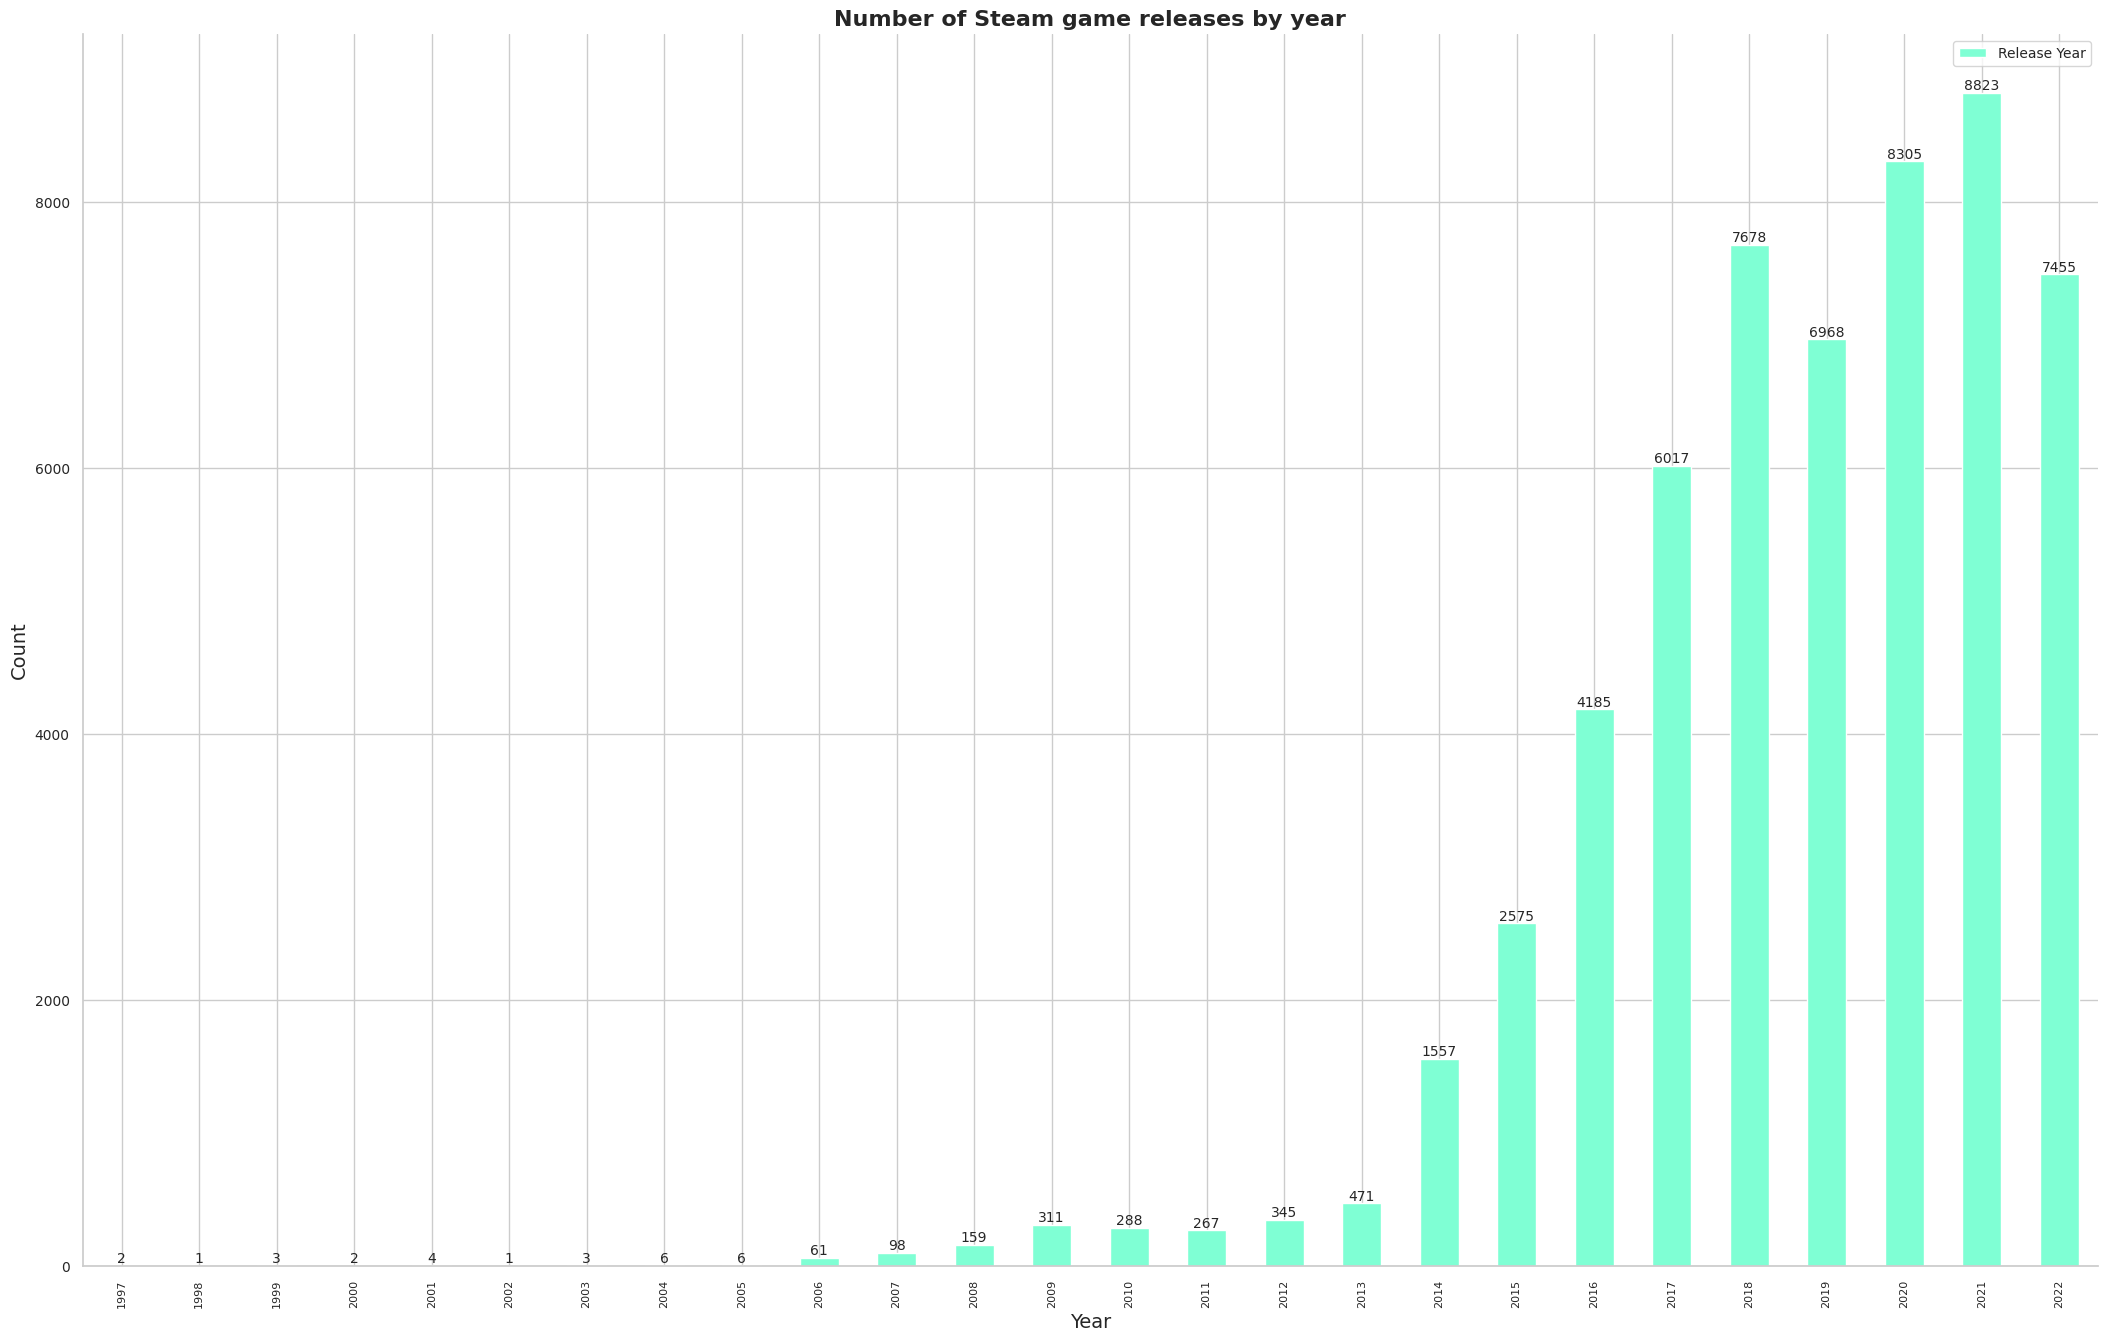

In [396]:
# bar chart of total released games in different year
# plt.figure(figsize=(14,7))
fig, ax = plt.subplots(figsize=(26, 16))
df_updated["Release Year"].value_counts().sort_index().plot(kind="bar", ax=ax, color="aquamarine")
ax.set_title('Number of Steam game releases by year', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='x', labelrotation=90, labelsize=8)
ax.tick_params(axis='y', labelsize=10)
ax.legend(fontsize=10, loc='upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10)


In [397]:
# drop release year columns

df_updated = df_updated.drop(['Release Year'], axis=1)

In [398]:
# checking shape of dataset
print(df_updated.shape, '\n')
print(df_updated.columns.tolist(), '\n')

(55591, 89) 

['Short Description', 'Tags', 'Owners', 'Positive Reviews', 'Negative Reviews', 'Price', 'Discount', 'CCU', 'Release Date', 'Required Age', 'Website', 'Release Month', 'Single-player_Categories', 'SteamAchievements_Categories', 'SteamCloud_Categories', 'Fullcontrollersupport_Categories', 'Multi-player_Categories', 'SteamTradingCards_Categories', 'PartialControllerSupport_Categories', 'PvP_Categories', 'Co-op_Categories', 'SteamLeaderoards_Categories', 'OnlinePvP_Categories', 'RemotePlayTogether_Categories', 'SharedSplitScreen_Categories', 'SharedSplitScreenPvP_Categories', 'OnlineCo-op_Categories', 'Stats_Categories', 'SharedSplitScreenCo-op_Categories', 'RemotePlayonTV_Categories', 'Cross-PlatformMultiplayer_Categories', 'Includesleveleditor_Categories', 'SteamWorkshop_Categories', 'In-AppPurchases_Categories', 'Captionsavailale_Categories', 'RemotePlayonTalet_Categories', 'MMO_Categories', 'RemotePlayonPhone_Categories', 'LANPvP_Categories', 'LANCo-op_Categories', 'Indi

In [399]:
# Descriptive Statistics (Price v.s. Rating)

# Create an empty summary table
summary_table = pd.DataFrame(columns=["Rating", "Mean", "Median", "Standard Deviation"])

# Iterate through the Rating values
for Rating in [0, 1, 2, 3]:
    # Filter the dataset where the "Rating" column equals the current Rating
    filtered_df = df_updated[df_updated["Rating"] == Rating]

    # Calculate mean, mode, median, and standard deviation for the "Price" column
    mean = filtered_df["Price"].mean()
    median = filtered_df["Price"].median()
    std_dev = filtered_df["Price"].std()

    # Append the calculated values to the summary table
    summary_table = summary_table.append({"Rating": Rating,
                                          "Mean": mean,
                                          "Median": median,
                                          "Standard Deviation": std_dev}, ignore_index=True)

# Visualize the summary table using the tabulate library
print(tabulate(summary_table, headers='keys', tablefmt='pretty', floatfmt=".2f", showindex=False))


+--------+-------------------+--------+--------------------+
| Rating |       Mean        | Median | Standard Deviation |
+--------+-------------------+--------+--------------------+
|  0.0   | 603.8245471349353 | 399.0  | 1005.5463909803769 |
|  1.0   | 615.4604706406354 | 499.0  | 1180.5353108844456 |
|  2.0   | 706.0569983597594 | 499.0  | 859.2580662833053  |
|  3.0   | 1162.404067893719 | 999.0  | 1205.9414153843175 |
+--------+-------------------+--------+--------------------+


<ipython-input-399-b539acb29643>:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-399-b539acb29643>:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-399-b539acb29643>:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-399-b539acb29643>:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



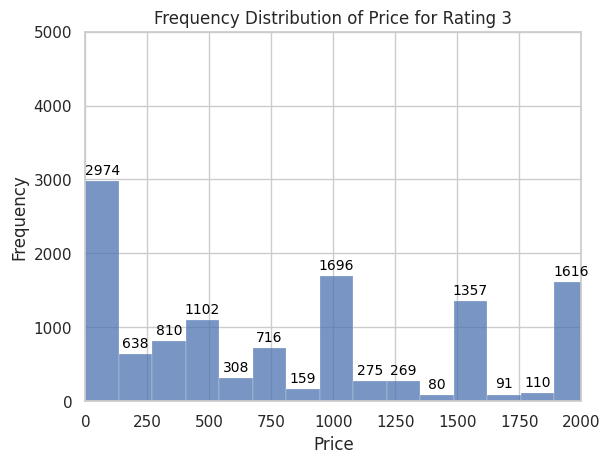

In [400]:
# Filter the dataset where the "Rating" column equals 3
filtered_df = df_updated[df_updated["Rating"] == 3]

# Set the style for the plot
sns.set(style="whitegrid")

# Create a histogram with smaller bins for the "Price" column for "Rating" equals 3
hist_plot = sns.histplot(data=filtered_df, x="Price", bins=200, kde=False)

# Set the title and labels for the plot
plt.title("Frequency Distribution of Price for Rating 3")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Set the x-axis limits for the plot
plt.xlim(0, 2000)
plt.ylim(0, 5000)

# Iterate through the histogram bars and add the count as text above each bar
for p in hist_plot.patches:
    hist_plot.annotate(f"{p.get_height()}", 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='baseline', 
                       fontsize=10, color='black',
                       xytext=(0, 5), textcoords='offset points')

# Display the plot
plt.show()

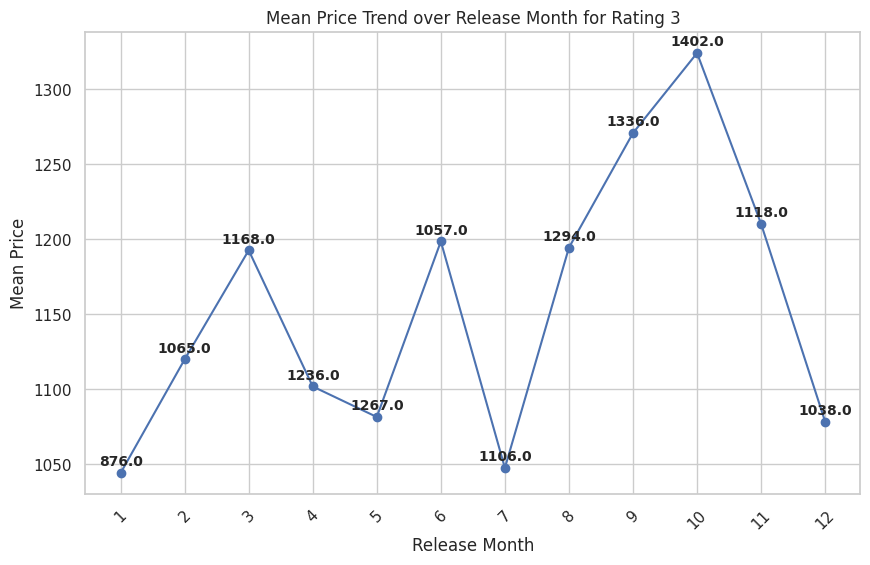

In [401]:
# Time-Series Analysis for Price over Release Month

# Filter the DataFrame for rows with Rating = 3
df_filtered = df_updated[df_updated['Rating'] == 3]

# Group the filtered DataFrame by Release Month, calculate the mean Price and count for each group
df_grouped = df_filtered.groupby('Release Month').agg({'Price': 'mean', 'Rating': 'count'}).reset_index()

# Create a line plot to show the trend of the mean Price over Release Month
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['Release Month'].astype(str), df_grouped['Price'], marker='o')

# Configure plot title, x and y labels
plt.title('Mean Price Trend over Release Month for Rating 3')
plt.xlabel('Release Month')
plt.ylabel('Mean Price')

# Add the number of data points for each group as annotations
for i, row in df_grouped.iterrows():
    plt.annotate(f'{row["Rating"]}', (i, row['Price']), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, fontweight='bold')

# Display the plot
plt.xticks(rotation=45)
plt.show()

In [402]:
# checking shape of dataset
print(df_filtered.shape, '\n')
print(df_filtered.columns.tolist(), '\n')

(13963, 89) 

['Short Description', 'Tags', 'Owners', 'Positive Reviews', 'Negative Reviews', 'Price', 'Discount', 'CCU', 'Release Date', 'Required Age', 'Website', 'Release Month', 'Single-player_Categories', 'SteamAchievements_Categories', 'SteamCloud_Categories', 'Fullcontrollersupport_Categories', 'Multi-player_Categories', 'SteamTradingCards_Categories', 'PartialControllerSupport_Categories', 'PvP_Categories', 'Co-op_Categories', 'SteamLeaderoards_Categories', 'OnlinePvP_Categories', 'RemotePlayTogether_Categories', 'SharedSplitScreen_Categories', 'SharedSplitScreenPvP_Categories', 'OnlineCo-op_Categories', 'Stats_Categories', 'SharedSplitScreenCo-op_Categories', 'RemotePlayonTV_Categories', 'Cross-PlatformMultiplayer_Categories', 'Includesleveleditor_Categories', 'SteamWorkshop_Categories', 'In-AppPurchases_Categories', 'Captionsavailale_Categories', 'RemotePlayonTalet_Categories', 'MMO_Categories', 'RemotePlayonPhone_Categories', 'LANPvP_Categories', 'LANCo-op_Categories', 'Indi

In [403]:
# normalization

df_updated = (df_updated - df_updated.min()) / (df_updated.max() - df_updated.min())

<Axes: >

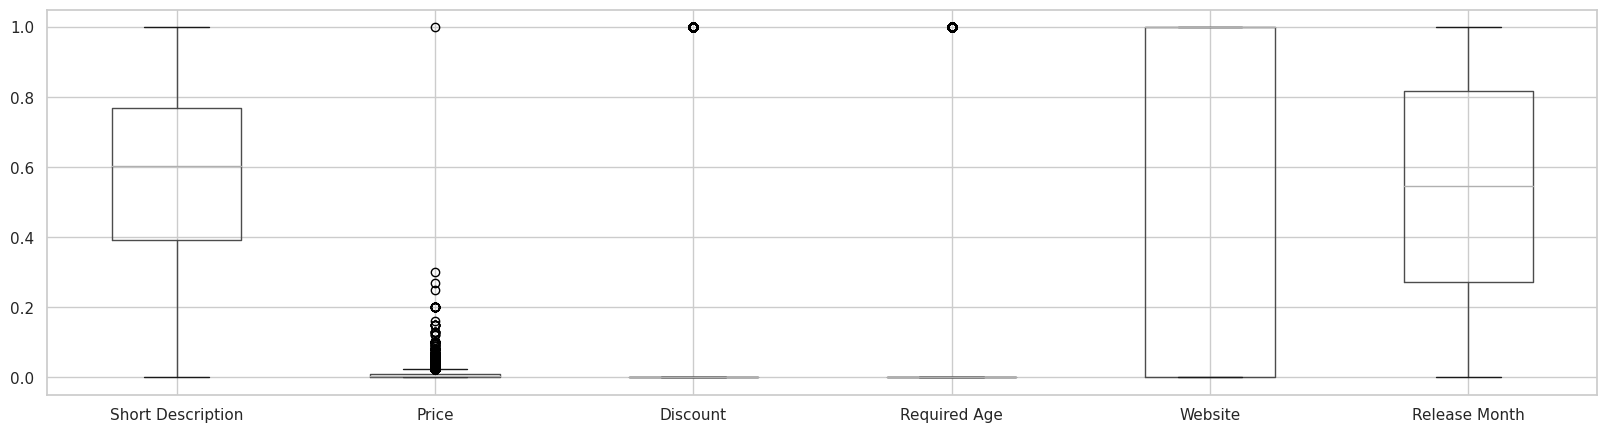

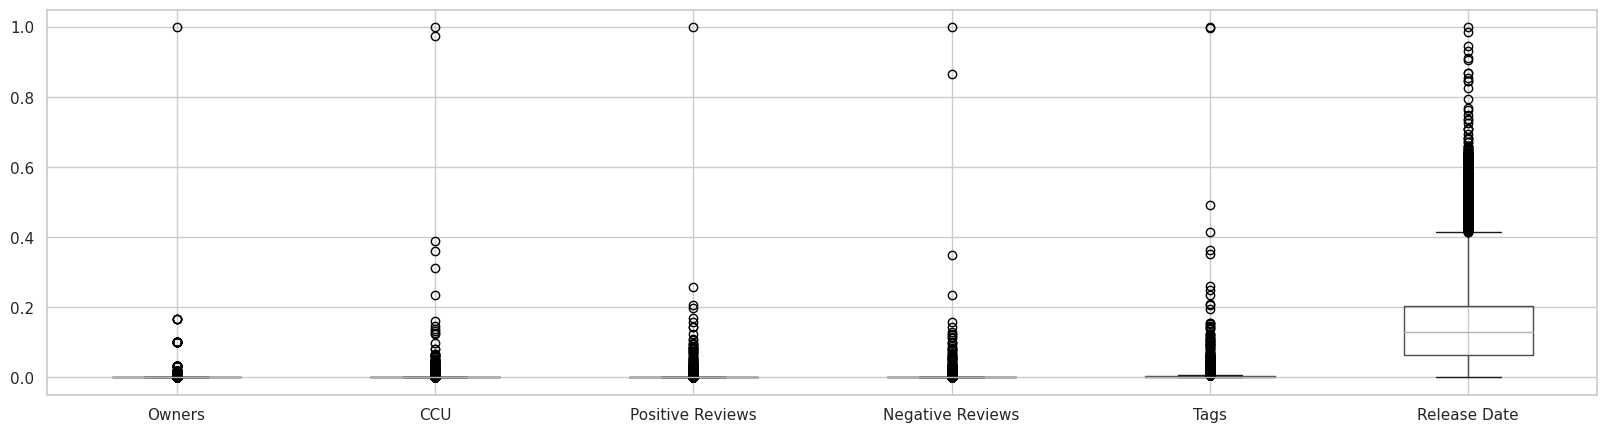

In [404]:
# boxplot

# input fields
plt.figure(figsize = (20,5))
df_updated.boxplot(column=['Short Description', 'Price', 'Discount', 'Required Age', 'Website', 'Release Month'])

# output fields
plt.figure(figsize = (20,5))
df_updated.boxplot(column=['Owners', 'CCU', 'Positive Reviews', 'Negative Reviews', 'Tags', 'Release Date'])

In [405]:
# [NOT USE] - try dropping more outlier rows from boxplot

df_updated_v2 = df_updated.copy()

for name in ['Short Description', 'Price', 'Discount', 'Required Age', 'Website', 'Release Month', 
             'Owners', 'CCU', 'Positive Reviews', 'Negative Reviews', 'Tags', 'Release Date']:
    
    Q1 = df_updated_v2[name].quantile(0.25)
    Q3 = df_updated_v2[name].quantile(0.75)
    IQR = Q3 - Q1

    filter = (df_updated_v2[name] >= Q1 - 1.5 * IQR) & (df_updated_v2[name] <= Q3 + 1.5 * IQR)
    df_updated_v2 = df_updated_v2.loc[filter]  

df_updated_v2

Short Description      Tags  Owners  Positive Reviews  \
1               0.789474  0.003289     0.0      4.542896e-06   
4               0.327485  0.000111     0.0      0.000000e+00   
6               0.362573  0.000132     0.0      3.028598e-06   
8               0.619883  0.000156     0.0      1.009533e-06   
9               0.836257  0.002867     0.0      5.384173e-06   
...                  ...       ...     ...               ...   
55684           0.412281  0.000063     0.0      1.177788e-06   
55686           0.441520  0.000043     0.0      2.019065e-06   
55687           0.836257  0.000081     0.0      3.365108e-07   
55689           0.871345  0.000106     0.0      3.365108e-07   
55690           0.473684  0.000486     0.0      1.682554e-06   

       Negative Reviews     Price  Discount  CCU  Release Date  Required Age  \
1              0.000006  0.010000       0.0  0.0      0.058931           0.0   
4              0.000001  0.001992       0.0  0.0      0.142688           0.0   
6              0.000007  0.013003       0.0  0.0      0.149703           0.0   
8              0.000000  0.002993       0.0  0.0      0.151646           0.0   
9              0.000013  0.014004       0.0  0.0      0.046195           0.0   
...                 ...       ...       ...  ...           ...           ...   
55684          0.000000  0.004995       0.0  0.0      0.153697           0.0   
55686          0.000003  0.000000       0.0  0.0      0.140637           0.0   
55687          0.000000  0.002993       0.0  0.0      0.141392           0.0   
55689          0.000002  0.004995       0.0  0.0      0.151106           0.0   
55690          0.000000  0.004995       0.0  0.0      0.125958           0.0   

       ...  Finnish_Languages  Norwegian_Languages  Greek_Languages  \
1      ...                0.0                  0.0              0.0   
4      ...                0.0                  0.0              0.0   
6      ...                0.0                  0.0              0.0   
8      ...                0.0                  0.0              0.0   
9      ...                0.0                  0.0              0.0   
...    ...                ...                  ...              ...   
55684  ...                0.0                  0.0              0.0   
55686  ...                0.0                  0.0              0.0   
55687  ...                0.0                  0.0              0.0   
55689  ...                0.0                  0.0              0.0   
55690  ...                0.0                  0.0              0.0   

       Romanian_Languages  Notsupported_Languages  Bulgarian_Languages  \
1                     0.0                     0.0                  0.0   
4                     0.0                     0.0                  0.0   
6                     0.0                     0.0                  0.0   
8                     0.0                     0.0                  0.0   
9                     0.0                     0.0                  0.0   
...                   ...                     ...                  ...   
55684                 0.0                     0.0                  0.0   
55686                 0.0                     0.0                  0.0   
55687                 0.0                     0.0                  0.0   
55689                 0.0                     0.0                  0.0   
55690                 0.0                     0.0                  0.0   

       Vietnamese_Languages  mac_Platforms  linux_Platforms    Rating  
1                       0.0            0.0              0.0  0.666667  
4                       0.0            0.0              0.0  0.000000  
6                       0.0            0.0              0.0  0.666667  
8                       0.0            1.0              0.0  0.333333  
9                       0.0            0.0              0.0  0.666667  
...                     ...            ...              ...       ...  
55684                   0.0    

In [406]:
# [NOT USE] - try dropping more outlier rows from boxplot - normalization

df_updated_v2 = (df_updated_v2 - df_updated_v2.min()) / (df_updated_v2.max() - df_updated_v2.min())

<Axes: >

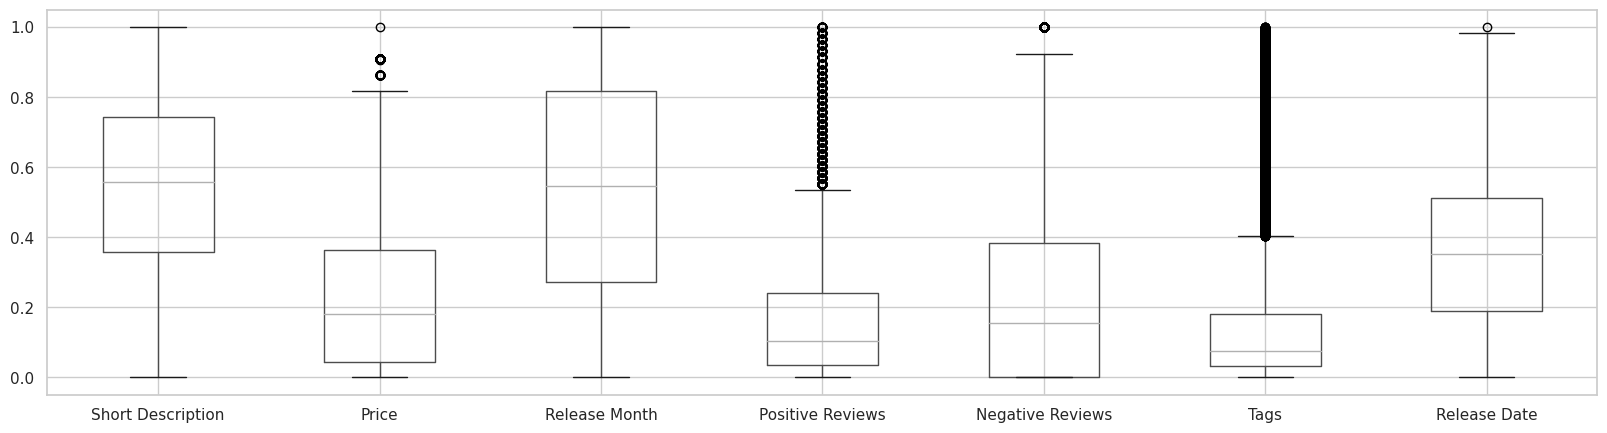

In [407]:
# [NOT USE] - try dropping more outlier rows from boxplot - boxplot

plt.figure(figsize = (20,5))
df_updated_v2.boxplot(column=['Short Description', 'Price', 'Release Month', 
                              'Positive Reviews', 'Negative Reviews', 'Tags', 'Release Date'])

<Axes: >

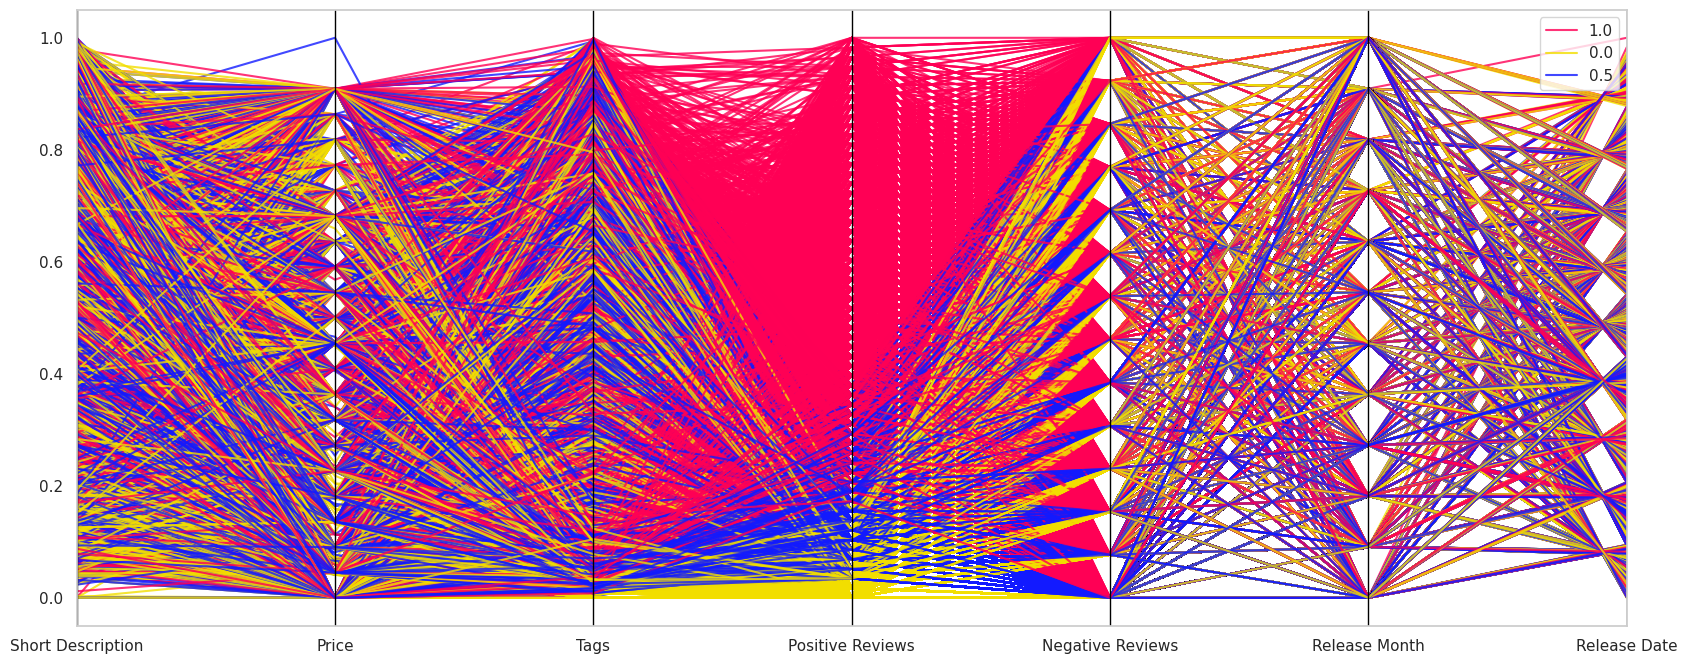

In [408]:
# [NOT USE] - try dropping more outlier rows from boxplot - Parallel Coordinates Plot

plt.figure(figsize = (20,8))
parallel_coordinates(df_updated_v2, class_column='Rating', 
                     cols=['Short Description', 'Price', 'Tags',  'Positive Reviews', 'Negative Reviews', 
                           'Release Month', 'Release Date'], 
                     color=('#ff0055', '#f2de00', '#121aff', '#951eb3', '#00cf1c'), alpha=0.8)

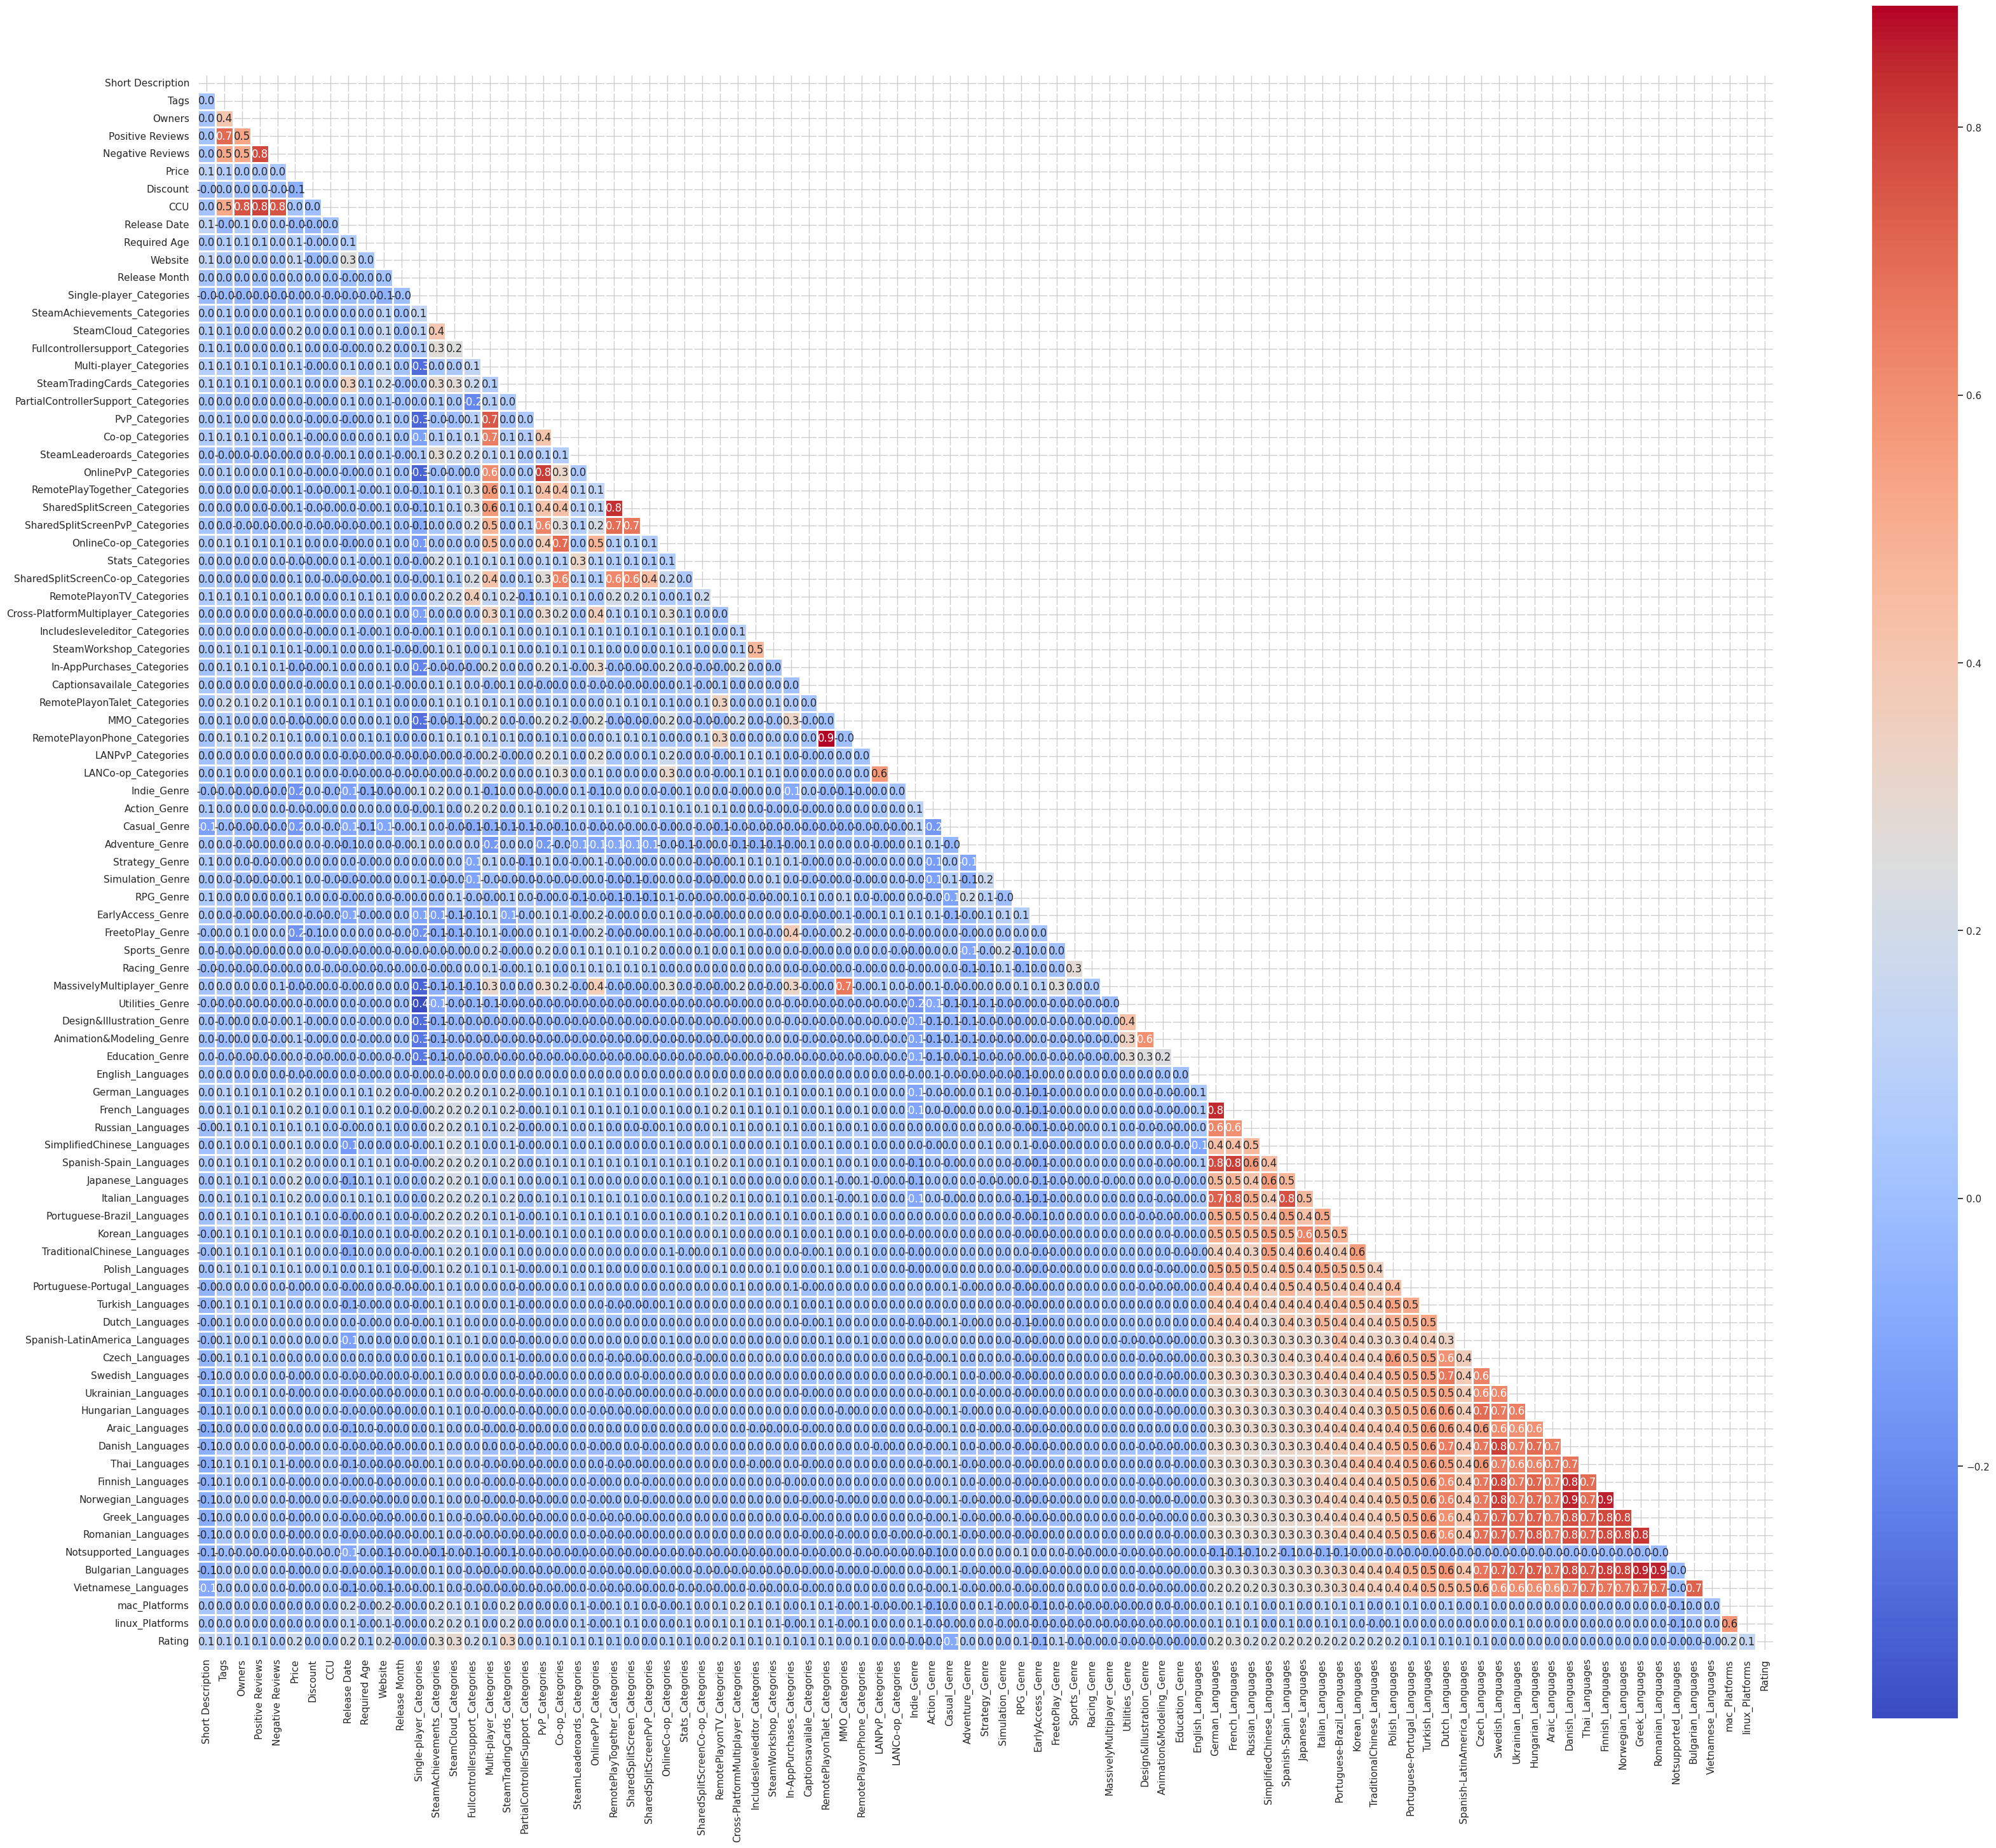

In [409]:
# Correlation

plt.figure(figsize = (40,35))
correlation_df = df_updated.corr()
mask = np.triu(correlation_df)
sns.heatmap(correlation_df,mask=mask, cmap='coolwarm', annot=True, square = True, fmt='.1f',linewidths = 1)
plt.show()

In [410]:
# drop useless output columns after grouping to 'Rating'

df_updated = df_updated.drop(['Owners', 'CCU', 'Positive Reviews', 'Negative Reviews', 'Tags', 'Release Date'], axis=1)
df_updated

Short Description     Price  Discount  Required Age  Website  \
0               0.921053  0.010000       0.0           0.0      0.0   
1               0.789474  0.010000       0.0           0.0      0.0   
2               0.865497  0.005996       1.0           0.0      0.0   
3               0.467836  0.020010       0.0           0.0      1.0   
4               0.327485  0.001992       0.0           0.0      0.0   
...                  ...       ...       ...           ...      ...   
55686           0.441520  0.000000       0.0           0.0      1.0   
55687           0.836257  0.002993       0.0           0.0      0.0   
55688           0.362573  0.000000       0.0           0.0      1.0   
55689           0.871345  0.004995       0.0           0.0      0.0   
55690           0.473684  0.004995       0.0           0.0      1.0   

       Release Month  Single-player_Categories  SteamAchievements_Categories  \
0           0.909091                       0.0                           0.0   
1           0.363636                       1.0                           1.0   
2           0.818182                       1.0                           1.0   
3           0.818182                       1.0                           1.0   
4           0.181818                       1.0                           0.0   
...              ...                       ...                           ...   
55686       0.272727                       0.0                           0.0   
55687       0.272727                       1.0                           0.0   
55688       0.000000                       0.0                           0.0   
55689       0.000000                       1.0                           0.0   
55690       0.727273                       1.0                           1.0   

       SteamCloud_Categories  Fullcontrollersupport_Categories  ...  \
0                        0.0                               0.0  ...   
1                        1.0                               0.0  ...   
2                        1.0                               0.0  ...   
3                        1.0                               1.0  ...   
4                        0.0                               0.0  ...   
...                      ...                               ...  ...   
55686                    0.0                               0.0  ...   
55687                    0.0                               0.0  ...   
55688                    0.0                               0.0  ...   
55689                    1.0                               0.0  ...   
55690                    1.0                               0.0  ...   

       Finnish_Languages  Norwegian_Languages  Greek_Languages  \
0                    0.0                  0.0              0.0   
1                    0.0                  0.0              0.0   
2                    0.0                  0.0              0.0   
3                    0.0                  0.0              0.0   
4                    0.0                  0.0              0.0   
...                  ...                  ...              ...   
55686                0.0                  0.0              0.0   
55687                0.0                  0.0              0.0   
55688                0.0                  0.0              0.0   
55689                0.0                  0.0              0.0   
55690                0.0                  0.0              0.0   

       Romanian_Languages  Notsupported_Languages  Bulgarian_Languages  \
0                     0.0                     0.0                  0.0   
1                     0.0                     0.0                  0.0   
2                     0.0                     0.0                  0.0   
3                     0.0                     0.0                  0.0   
4                     0.0                     0.0                  0.0   
...                   ...                     ...                  ...   
55686                 0.0    

In [414]:
df_updated.columns

Index(['Short Description', 'Price', 'Discount', 'Required Age', 'Website',
       'Release Month', 'Single-player_Categories',
       'SteamAchievements_Categories', 'SteamCloud_Categories',
       'Fullcontrollersupport_Categories', 'Multi-player_Categories',
       'SteamTradingCards_Categories', 'PartialControllerSupport_Categories',
       'PvP_Categories', 'Co-op_Categories', 'SteamLeaderoards_Categories',
       'OnlinePvP_Categories', 'RemotePlayTogether_Categories',
       'SharedSplitScreen_Categories', 'SharedSplitScreenPvP_Categories',
       'OnlineCo-op_Categories', 'Stats_Categories',
       'SharedSplitScreenCo-op_Categories', 'RemotePlayonTV_Categories',
       'Cross-PlatformMultiplayer_Categories',
       'Includesleveleditor_Categories', 'SteamWorkshop_Categories',
       'In-AppPurchases_Categories', 'Captionsavailale_Categories',
       'RemotePlayonTalet_Categories', 'MMO_Categories',
       'RemotePlayonPhone_Categories', 'LANPvP_Categories',
       'LANCo-op_Ca

In [415]:
df_updated['Rating'].value_counts()

0.666667    14632
1.000000    13963
0.000000    13525
0.333333    13471
Name: Rating, dtype: int64

In [416]:
# filter the upper-tier collection and count each category and genre
df_upper_tier = df_updated[df_updated['Rating'].isin([1])]
print(df_upper_tier['Rating'].value_counts(), '\n')
counts_categories_genres = df_upper_tier.groupby('Rating')['Single-player_Categories', 'SteamAchievements_Categories',
       'SteamCloud_Categories', 'Fullcontrollersupport_Categories',
       'Multi-player_Categories', 'SteamTradingCards_Categories',
       'PartialControllerSupport_Categories', 'PvP_Categories',
       'Co-op_Categories', 'SteamLeaderoards_Categories',
       'OnlinePvP_Categories', 'RemotePlayTogether_Categories',
       'SharedSplitScreen_Categories', 'SharedSplitScreenPvP_Categories',
       'OnlineCo-op_Categories', 'Stats_Categories',
       'SharedSplitScreenCo-op_Categories', 'RemotePlayonTV_Categories',
       'Cross-PlatformMultiplayer_Categories',
       'Includesleveleditor_Categories', 'SteamWorkshop_Categories',
       'In-AppPurchases_Categories', 'Captionsavailale_Categories',
       'RemotePlayonTalet_Categories', 'MMO_Categories',
       'RemotePlayonPhone_Categories', 'LANPvP_Categories',
       'LANCo-op_Categories', 'Indie_Genre', 'Action_Genre', 'Casual_Genre',
       'Adventure_Genre', 'Strategy_Genre', 'Simulation_Genre', 'RPG_Genre',
       'EarlyAccess_Genre', 'FreetoPlay_Genre', 'Sports_Genre', 'Racing_Genre',
       'MassivelyMultiplayer_Genre', 'Utilities_Genre',
       'Design&Illustration_Genre', 'Animation&Modeling_Genre',
       'Education_Genre'].sum()

# Print the resulting dataframe
print(counts_categories_genres)

1.0    13963
Name: Rating, dtype: int64 

        Single-player_Categories  SteamAchievements_Categories  \
Rating                                                           
1.0                      13025.0                        9334.0   

        SteamCloud_Categories  Fullcontrollersupport_Categories  \
Rating                                                            
1.0                    6442.0                            4328.0   

        Multi-player_Categories  SteamTradingCards_Categories  \
Rating                                                          
1.0                      4160.0                        5560.0   

        PartialControllerSupport_Categories  PvP_Categories  Co-op_Categories  \
Rating                                                                          
1.0                                  2304.0          2237.0            2186.0   

        SteamLeaderoards_Categories  ...  RPG_Genre  EarlyAccess_Genre  \
Rating                               ...   

<ipython-input-416-7566e31bd712>:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [417]:
# transform result table to dataframe
df_upper_tier_collection = pd.DataFrame(counts_categories_genres)
print(df_upper_tier_collection.shape, '\n')

(1, 44) 



In [418]:
# Filter the Genre and Categories into different dataframe
df_genre_records = (df_upper_tier_collection.loc[1.0].filter(regex='_Genre$'))
df_category_records = (df_upper_tier_collection.loc[1.0].filter(regex='_Categories$'))

# Sort the dataframe from above
sorted_df_genre_records = df_genre_records.sort_values(ascending=False)
sorted_df_category_records = df_category_records.sort_values(ascending=False)

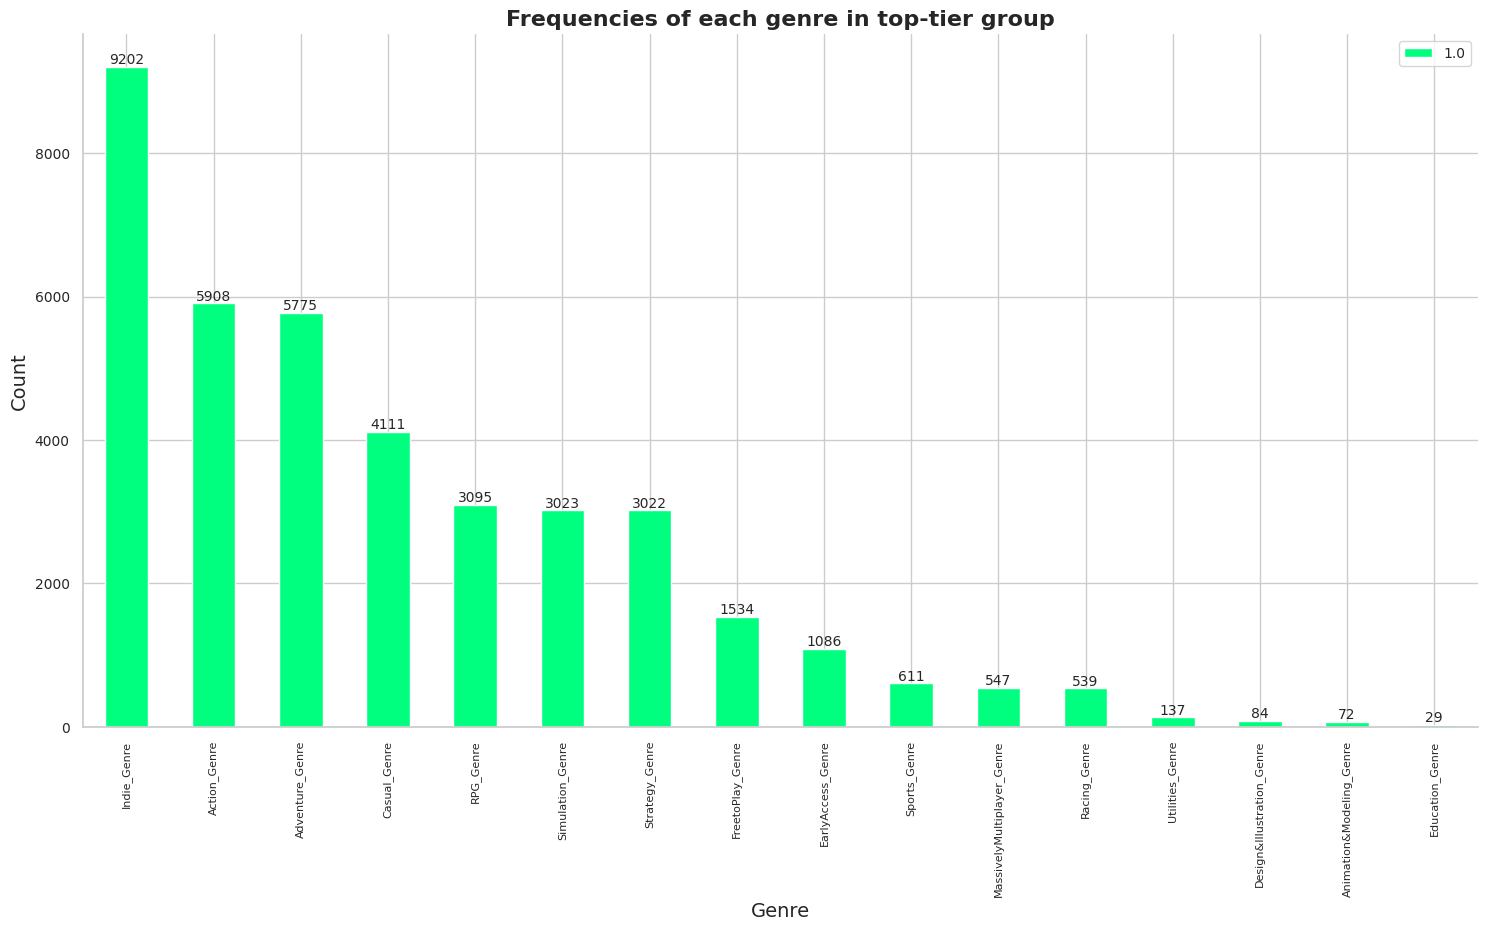

In [419]:
fig, ax = plt.subplots(figsize=(18, 9))
sorted_df_genre_records.plot(kind='bar', ax=ax, color='#00ff7f')

# Set the title and axis labels
# ax.set_title('Column values sorted in descending order', fontsize=14, fontweight='bold')
ax.set_title('Frequencies of each genre in top-tier group', fontsize=16, fontweight='bold')
ax.set_xlabel('Genre', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Set the tick labels and legend
ax.tick_params(axis='x', labelrotation=90, labelsize=8)
ax.tick_params(axis='y', labelsize=10)
ax.legend(fontsize=10, loc='upper right')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the exact values on top of each bar
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10)

# Show the plot
plt.show()

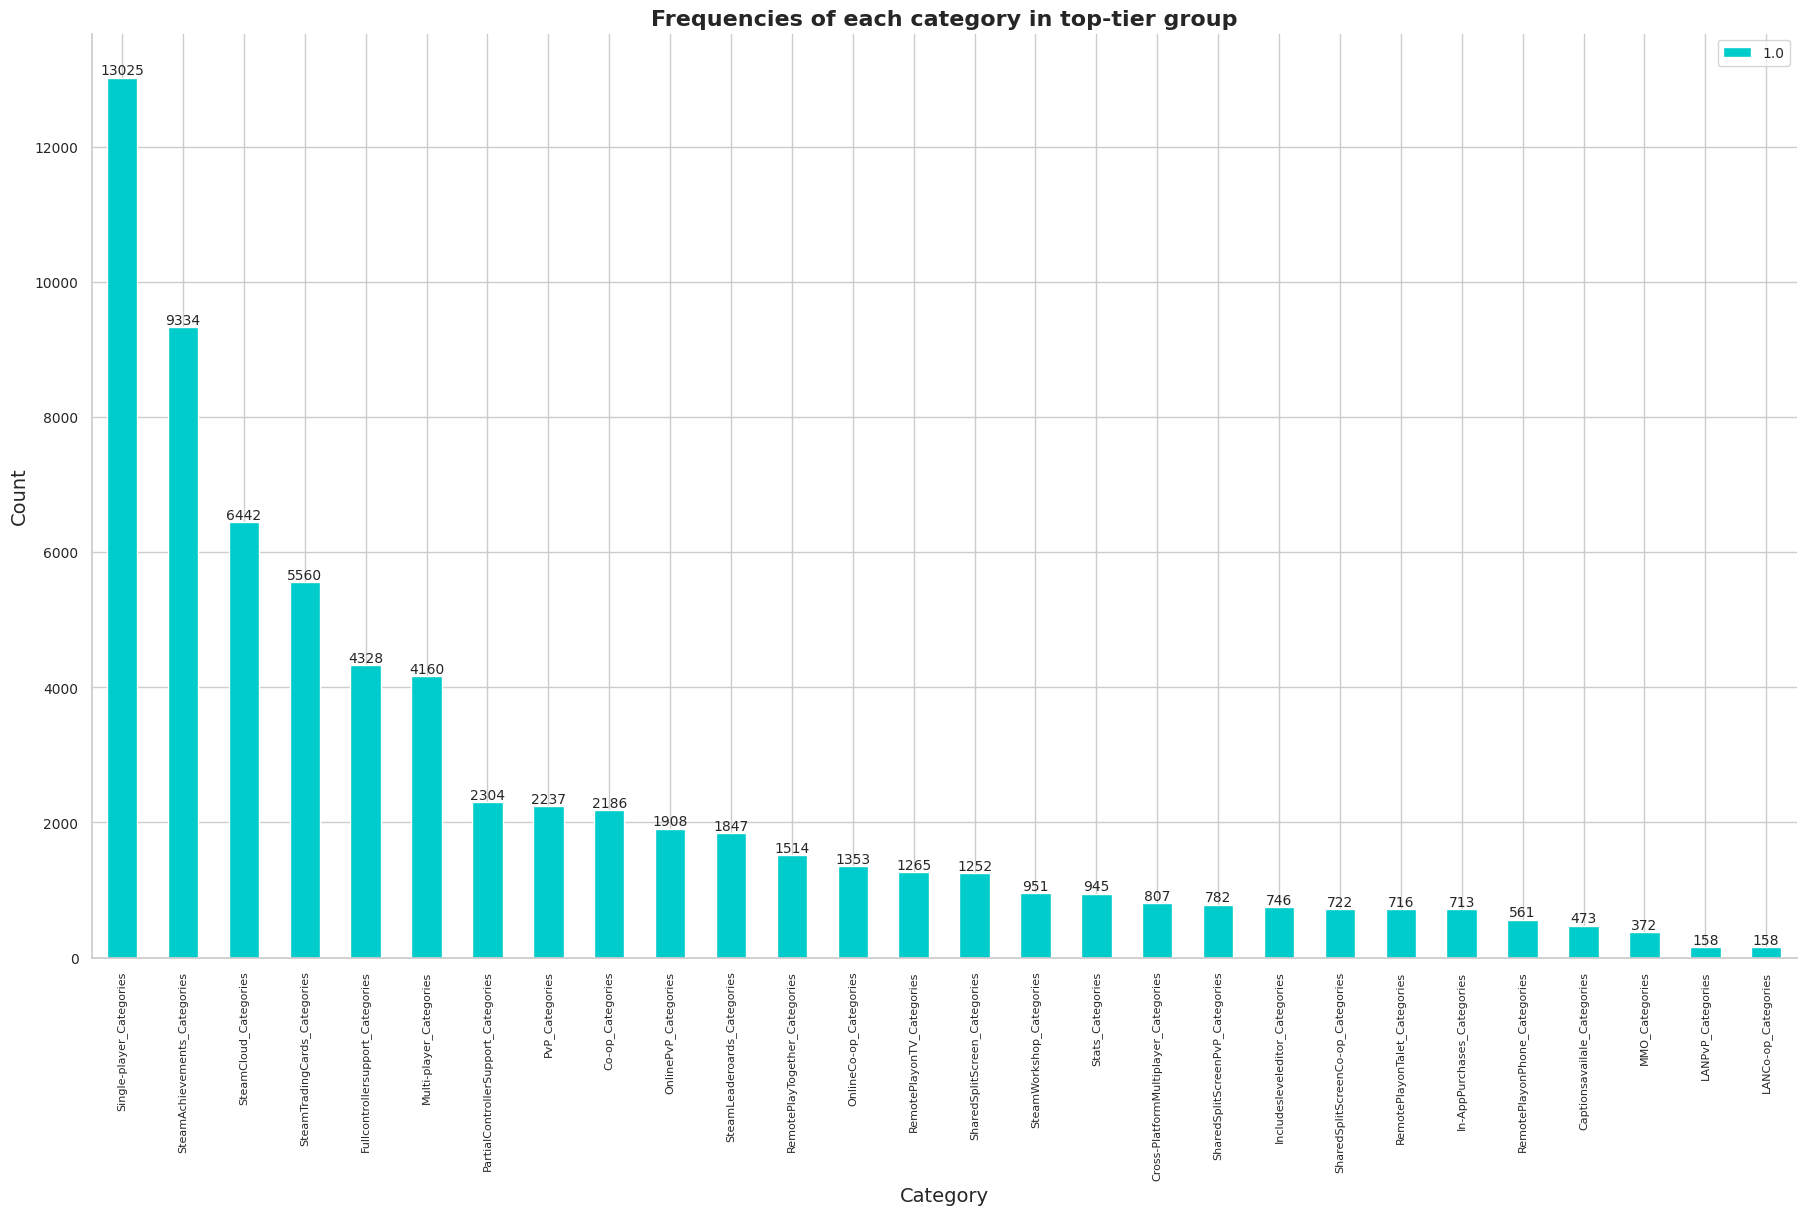

In [420]:
fig, ax = plt.subplots(figsize=(22, 12))
sorted_df_category_records.plot(kind='bar', ax=ax, color='#00cccc')

# Set the title and axis labels
# ax.set_title('Column values sorted in descending order', fontsize=14, fontweight='bold')
ax.set_title('Frequencies of each category in top-tier group', fontsize=16, fontweight='bold')
ax.set_xlabel('Category', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Set the tick labels and legend
ax.tick_params(axis='x', labelrotation=90, labelsize=8)
ax.tick_params(axis='y', labelsize=10)
ax.legend(fontsize=10, loc='upper right')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the exact values on top of each bar
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10)

# Show the plot
plt.show()

In [421]:
"""
Hypothesis Testing - T-test: 

                The null hypothesis for this test is that the groups have equal means 
                or that there is no significant difference between the average scores 
                of the two groups in the population.

Null Hypothesis (𝐻0): There is no statistical difference between the Rating mean of 
                        ([column_names] == true) and ([column_names] == false)

Alternative Hypothesis (𝐻1):  There is a statistical difference between the Rating mean of 
                        ([column_names] == true) and ([column_names] == false)

"""

df_ttest = df_updated.drop(['Short Description', 'Price', 'Release Month'], axis=1)
column_names_ttest = df_ttest.columns.values.tolist()
column_names_ttest.remove('Rating')
P=0.05
no_stat_diff_column_name = []

for name in column_names_ttest:
    
    # Creating data groups
    data_group_True = df_ttest.loc[df_ttest[name] == 1.0]
    data_group_False = df_ttest.loc[df_ttest[name] == 0.0]

    # Perform the two sample t-test with equal variances
    statistic, pvalue = stats.ttest_ind(data_group_True['Rating'], data_group_False['Rating'], equal_var=True)
    print(f"----------------- {name} <-> Rating -----------------: ")
    print('T-test: P-VALUE = ' + str(pvalue))
    
    if pvalue > P:
        print("We fail to reject the Null Hypothesis since our P-VALUE is more than 0.05 \n \n")
        no_stat_diff_column_name.append(name)
    else:
        print("We reject the Null Hypothesis since our P-VALUE is less than 0.05 \n \n")
        
no_stat_diff_column_name

----------------- Discount <-> Rating -----------------: 
T-test: P-VALUE = 2.707664414003893e-26
We reject the Null Hypothesis since our P-VALUE is less than 0.05 
 

----------------- Required Age <-> Rating -----------------: 
T-test: P-VALUE = 1.9674379763169064e-43
We reject the Null Hypothesis since our P-VALUE is less than 0.05 
 

----------------- Website <-> Rating -----------------: 
T-test: P-VALUE = 0.0
We reject the Null Hypothesis since our P-VALUE is less than 0.05 
 

----------------- Single-player_Categories <-> Rating -----------------: 
T-test: P-VALUE = 5.221024434060043e-05
We reject the Null Hypothesis since our P-VALUE is less than 0.05 
 

----------------- SteamAchievements_Categories <-> Rating -----------------: 
T-test: P-VALUE = 0.0
We reject the Null Hypothesis since our P-VALUE is less than 0.05 
 

----------------- SteamCloud_Categories <-> Rating -----------------: 
T-test: P-VALUE = 0.0
We reject the Null Hypothesis since our P-VALUE is less than 0.

['Simulation_Genre',
 'Design&Illustration_Genre',
 'Animation&Modeling_Genre',
 'English_Languages',
 'Bulgarian_Languages',
 'Vietnamese_Languages']

In [422]:
# Assoication Rule Mining - Apriori Algorithm

df_updated_arm = df_updated.copy()
df_updated_arm = df_updated_arm.drop(['Short Description', 'Price', 'Release Month', 'Rating', 
                                      'Single-player_Categories', 'English_Languages'], axis=1)

frequent_itemsets = apriori(df_updated_arm, min_support=0.3, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x:len(x))
print(frequent_itemsets)

rule_df = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rule_df = rule_df[(rule_df['lift'] > 1) & (rule_df['confidence'] >= 0.5)]
rule_df.drop(columns = ['antecedent support', 'consequent support', 'leverage', 'conviction'])

    support                                     itemsets  length
0  0.546959                                    (Website)       1
1  0.492292               (SteamAchievements_Categories)       1
2  0.713425                                (Indie_Genre)       1
3  0.426850                               (Action_Genre)       1
4  0.396935                               (Casual_Genre)       1
5  0.384990                            (Adventure_Genre)       1
6  0.380619                       (Indie_Genre, Website)       2
7  0.387815  (Indie_Genre, SteamAchievements_Categories)       2
8  0.330395                  (Action_Genre, Indie_Genre)       2
9  0.309241                  (Casual_Genre, Indie_Genre)       2


antecedents                     consequents   support  \
2                   (Indie_Genre)  (SteamAchievements_Categories)  0.387815   
3  (SteamAchievements_Categories)                   (Indie_Genre)  0.387815   
4                  (Action_Genre)                   (Indie_Genre)  0.330395   
5                  (Casual_Genre)                   (Indie_Genre)  0.309241   

   confidence      lift  
2    0.543596  1.104214  
3    0.787774  1.104214  
4    0.774032  1.084952  
5    0.779072  1.092017

In [423]:
# Splitting dataset

X = df_updated.iloc[:, 0:-1]
y = df_updated.iloc[:, -1]

print(y.value_counts())
class_name_list = [ '%.2f' % elem for elem in list(y.value_counts().keys()) ]
class_name_list.sort()

y = y * (len(class_name_list) - 1)
y = y.apply(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

models = {}

0.666667    14632
1.000000    13963
0.000000    13525
0.333333    13471
Name: Rating, dtype: int64
(44472, 82)
(11119, 82)
(44472,)
(11119,)


In [ ]:
# NN model

class NNModel():
    def __init__(self):
        self.history_dict = {}
        self._estimator_type = "classifier"
        
    def define_structure(self, X, y):
        self.model = Sequential()
        self.model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
        self.model.add(Dense(16, activation='relu'))
        self.model.add(Dense(8, activation='relu'))
        self.model.add(Dense(y.shape[1], activation='softmax'))
        self.model.summary()

        self.model.compile(optimizer='adam', 
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        self.es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           mode='min',
                                           patience=10, 
                                           restore_best_weights=True)
    
    def fit(self, X_train, y_train):
        encoder = LabelEncoder()
        encoder.fit(y_train)
        encoded_Y = encoder.transform(y_train)
        dummy_y = np_utils.to_categorical(encoded_Y)
        print(dummy_y.shape)
        
        self.define_structure(X_train, dummy_y)

        history = self.model.fit(np.array(X_train),
                            np.array(dummy_y),
                            callbacks=[self.es],
                            epochs=100,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.2,
                            verbose=1)
        self.history_dict = history.history
        
    def predict(self, X_test):
        return self.model.predict(X_test).argmax(axis=1)
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return accuracy_score(y_test, y_pred)
        
    def plot(self):
        acc = self.history_dict['accuracy']
        val_acc = self.history_dict['val_accuracy']
        loss = self.history_dict['loss']
        val_loss = self.history_dict['val_loss']
        
        epochs = range(1, len(acc) + 1)

        plt.figure(figsize = (10,5))
        plt.plot(epochs, acc, 'r', label='Training accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
        plt.title('NN model - Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        plt.figure(figsize = (10,5))
        plt.plot(epochs, loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('NN model - Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    def get_params(self, deep=False):
        return {}

In [ ]:
# Hyperparameter tuning - GridSearchCV for Decision Tree - preventing from overfitting

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : list(range(5, 26)),
              'criterion' :['gini', 'entropy']
             }
grid_search = GridSearchCV(estimator=tree.DecisionTreeClassifier(), param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)
models['dt'] = grid_search.best_estimator_
print('GridSearchCV - best estimator (dt): ', models['dt'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


Fitting 5 folds for each of 378 candidates, totalling 1890 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Progr

GridSearchCV - best estimator (dt):  DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=18,
                       max_features='sqrt')


In [ ]:
# Hyperparameter tuning - GridSearchCV for Random Forest - preventing from overfitting

criterion = grid_search.best_params_["criterion"]
max_depth = grid_search.best_params_["max_depth"]
max_features = grid_search.best_params_["max_features"]

param_grid = {
    'n_estimators': list(range(10,320,10))
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features), 
    param_grid=param_grid, 
    cv=5, verbose=True
)
grid_search.fit(X_train, y_train)
models['rf'] = grid_search.best_estimator_
print('GridSearchCV - best estimator (rf): ', models['rf'])

Fitting 5 folds for each of 31 candidates, totalling 155 fits
GridSearchCV - best estimator (rf):  RandomForestClassifier(criterion='entropy', max_depth=18, n_estimators=280)


In [ ]:
# model list

models['svm'] = svm.LinearSVC(dual=False)
models['knn'] = KNeighborsClassifier(n_neighbors=2)
models['lr'] = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
models['lgbm'] = lgb.LGBMClassifier()
models['xgboost'] = XGBClassifier(eval_metric='mlogloss')
models['nn'] = NNModel()

# Hard voting entails picking the prediction with the highest number of votes, 
# whereas soft voting entails combining the probabilities of each prediction in each model 
# and picking the prediction with the highest total probability.
models['ensemble'] = VotingClassifier(estimators=[
                                                  ('rf', models['rf']),
                                                  ('svm', models['svm']),
                                                  ('knn', models['knn']),
                                                  ('dt', models['dt']), 
                                                  ('lr', models['lr']),
                                                  ('lgbm', models['lgbm']),
                                                  ('xgboost', models['xgboost']),
                                                  ('nn', models['nn'])
                                                 ], voting='hard')

<AxesSubplot:xlabel='PCA Variance'>

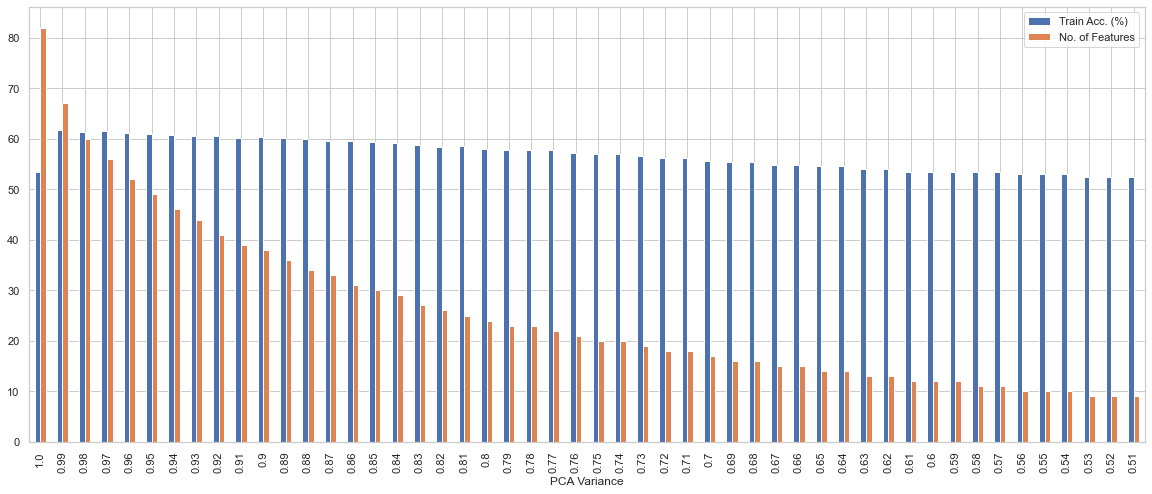

In [ ]:
# PCA -> find optional k

key = 'lgbm' # TODO - change to other models to test
train_accuray_k = []
column_len_k = []
explained_variance_k = []
max_variance_k = []

# without reduced
models[key].fit(X_train, y_train)
y_pred_train = models[key].predict(X_train)
train_acc = accuracy_score(y_train, y_pred_train)
train_accuray_k.append(train_acc * 100)
column_len_k.append(X_train.shape[1])
max_variance_k.append(1)

# with reduced
for n_components in list(np.around(np.arange(0.99, 0.5, -0.01), 2)):
    pca = PCA(n_components = n_components)
    X_train_reduced = pca.fit_transform(X_train)
    
    models[key].fit(X_train_reduced, y_train)
    y_pred_train = models[key].predict(X_train_reduced)
    train_acc = accuracy_score(y_train, y_pred_train)
    
    max_variance_k.append(n_components)
    train_accuray_k.append(train_acc * 100)
    column_len_k.append(X_train_reduced.shape[1])
    explained_variance_k.append(sum(pca.explained_variance_ratio_))

pca_df = pd.DataFrame(list(zip(max_variance_k, train_accuray_k, column_len_k)),
               columns =['PCA Variance', 'Train Acc. (%)', 'No. of Features'])
pca_df.plot(
    x="PCA Variance", y=['Train Acc. (%)', 'No. of Features'], kind="bar", figsize=(20,8)
)

In [ ]:
# dimension reduction

pca = PCA(n_components = 0.98)
X_train_reduced = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

X_test_reduced = pca.transform(X_test)
print(X_train_reduced.shape)
print(X_test_reduced.shape)

[0.17297927 0.07635224 0.06133251 0.04689402 0.04553505 0.03568729
 0.03354238 0.03170894 0.02837352 0.0282947  0.02518867 0.0245047
 0.02196701 0.02139724 0.01975355 0.01826387 0.01697703 0.01645317
 0.01394798 0.01373722 0.01304364 0.01258193 0.01195538 0.0112656
 0.01019927 0.00932083 0.00916122 0.00880907 0.00758527 0.00745518
 0.00733385 0.0068097  0.00661111 0.00641839 0.00631476 0.00605445
 0.00583866 0.00554281 0.00536195 0.00504108 0.00495788 0.00484943
 0.00454563 0.00429717 0.00411156 0.00403419 0.00358182 0.00347353
 0.00335184 0.00333864 0.00300928 0.00272667 0.00267006 0.00261782
 0.00239862 0.00239148 0.00226047 0.0021529  0.00185705 0.00183073]
0.9800512558695306
(44472, 60)
(11119, 60)


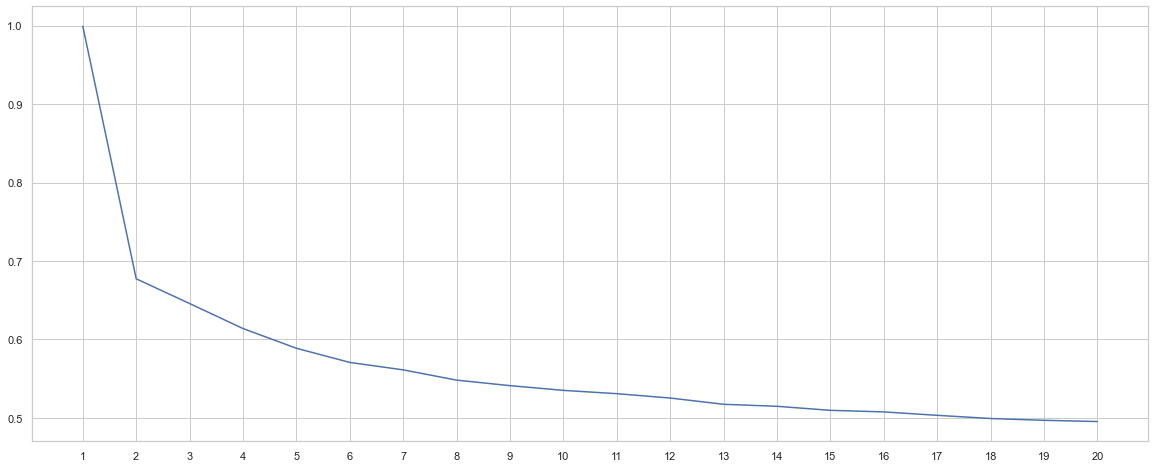

In [ ]:
# k-NN - find optimal k from elbow method

highest_train_accuracy = 0
train_accuray_k = []
max_k = 20

for k in range(1, max_k + 1):
    neigh = KNeighborsClassifier(n_neighbors=k)

    neigh.fit(X_train, y_train)
    y_pred_train = neigh.predict(X_train)
    y_pred_test = neigh.predict(X_test)
    
    acc_temp = accuracy_score(y_train, y_pred_train)
    train_accuray_k.append(acc_temp)
    if highest_train_accuracy < acc_temp:
        highest_train_accuracy = acc_temp
        

plt.figure(figsize = (20,8))
plt.xticks(np.arange(1, max_k + 2, 1.0))
plt.plot([*range(1, max_k + 1)], train_accuray_k)

In [ ]:
# model training

model_names = []

train_acc_list = []
validation_acc_list = []
test_acc_list = []

train_acc_reduced_list = []
validation_acc_reduced_list = []
test_acc_reduced_list = []

training_time = []
prediction_time = []
training_reduced_time = []
prediction_reduced_time = []

k_folds = KFold(n_splits = 5)

for key, model in models.items():
    print(f"----------------- {key} -----------------: ")
    model_names.append(key)
    
    # with reduced
    start_time = time.time()
    model.fit(X_train_reduced, y_train)
    training_reduced_time.append(time.time() - start_time)
    y_pred_train = model.predict(X_train_reduced)
    start_time = time.time()
    y_pred_test = model.predict(X_test_reduced)
    prediction_reduced_time.append(time.time() - start_time)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    print(X_train_reduced.shape)
    print("training accuracy: ", train_acc)
    
    # K-fold Cross-Validation
    score = cross_val_score(model, X_train_reduced, y_train, cv = k_folds).mean()
    validation_acc_reduced_list.append(score)
    print("Average CV Score: ", score)

    test_acc = accuracy_score(y_test, y_pred_test)
    print("testing accuracy: ", test_acc)
    train_acc_reduced_list.append(train_acc)
    test_acc_reduced_list.append(test_acc)
    
    # without reduced
    start_time = time.time()
    model.fit(X_train, y_train)    
    training_time.append(time.time() - start_time)
    y_pred_train = model.predict(X_train)
    start_time = time.time()
    y_pred_test = model.predict(X_test)
    prediction_time.append(time.time() - start_time)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    print(X_train.shape)
    print("training accuracy: ", train_acc)
    
    # K-fold Cross-Validation
    score = cross_val_score(model, X_train, y_train, cv = k_folds).mean()
    validation_acc_list.append(score)
    print("Average CV Score: ", score)
    
    test_acc = accuracy_score(y_test, y_pred_test)
    print("testing accuracy: ", test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    print("\n")


----------------- dt -----------------: 
(44472, 60)
training accuracy:  0.3926965281525454
Average CV Score:  0.38536634773959444
testing accuracy:  0.37890098030398417
(44472, 82)
training accuracy:  0.4019158121964382
Average CV Score:  0.39368594929753503
testing accuracy:  0.39535929490062055


----------------- rf -----------------: 
(44472, 60)
training accuracy:  0.9429978413383702
Average CV Score:  0.4429303748995255
testing accuracy:  0.4452738555625506
(44472, 82)
training accuracy:  0.7874168015830185
Average CV Score:  0.45770379333738076
testing accuracy:  0.45885421350840905


----------------- svm -----------------: 
(44472, 60)
training accuracy:  0.425975894945134
Average CV Score:  0.42073663292847757
testing accuracy:  0.4191923734148754
(44472, 82)
training accuracy:  0.43011332973556393
Average CV Score:  0.4239072137231042
testing accuracy:  0.42449860598974726


----------------- knn -----------------: 
(44472, 60)
training accuracy:  0.6775274329915453
Average

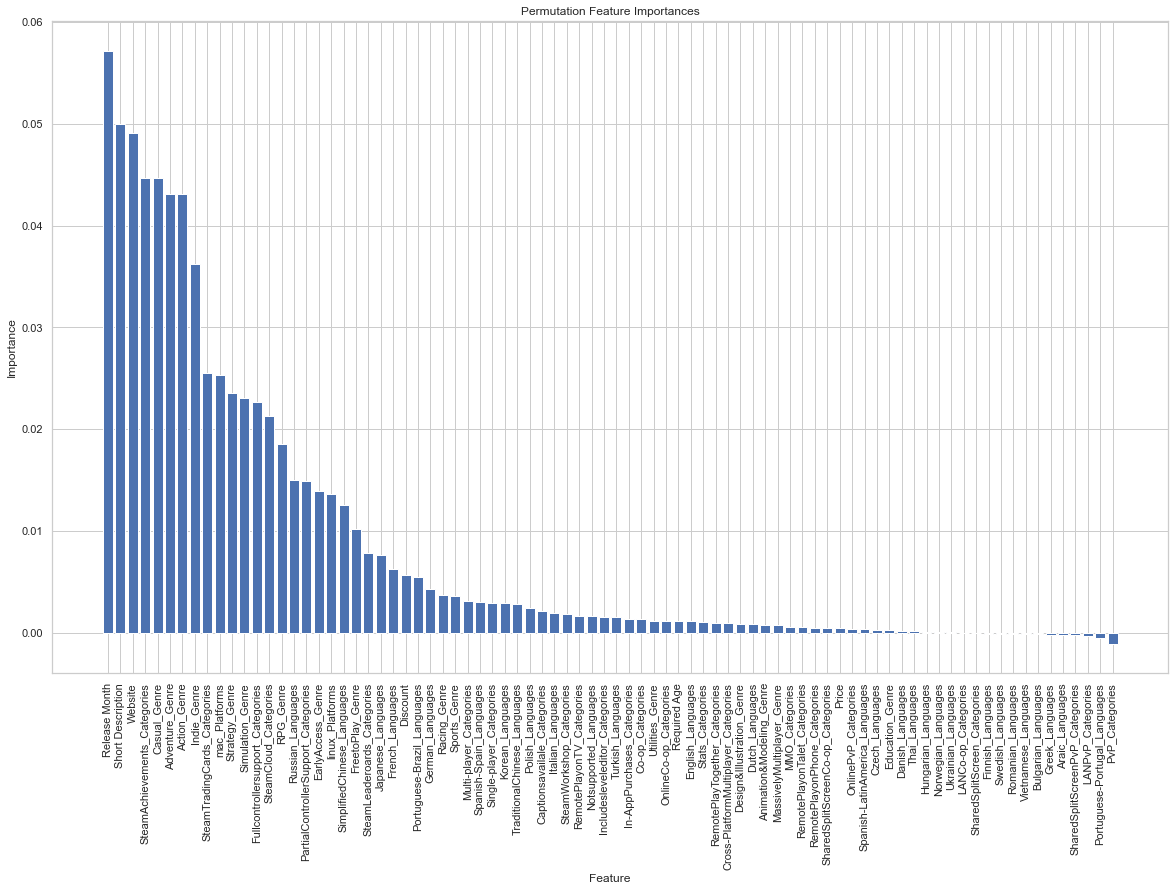

In [ ]:
# k-nn - evaluation
result = permutation_importance(models['knn'], X_train, y_train, n_repeats=3)

# Plot the feature importances
importances = result.importances_mean
features = list(X_train.columns)
indices = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in indices]

plt.figure(figsize = (20,12))
plt.bar(sorted_features, importances[indices])
plt.xticks(rotation=90)
plt.title('Permutation Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
# decision tree - evaluation

print(tree.export_text(models['dt'], feature_names=list(X_train.columns)))


|--- Price <= 0.01
|   |--- mac_Platforms <= 0.50
|   |   |--- SteamTradingCards_Categories <= 0.50
|   |   |   |--- TraditionalChinese_Languages <= 0.50
|   |   |   |   |--- Spanish-Spain_Languages <= 0.50
|   |   |   |   |   |--- In-AppPurchases_Categories <= 0.50
|   |   |   |   |   |   |--- Price <= 0.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Price >  0.00
|   |   |   |   |   |   |   |--- Website <= 0.50
|   |   |   |   |   |   |   |   |--- SteamLeaderoards_Categories <= 0.50
|   |   |   |   |   |   |   |   |   |--- Japanese_Languages <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- SteamAchievements_Categories <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- SteamAchievements_Categories >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |   |--- Japanese_Languages >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |

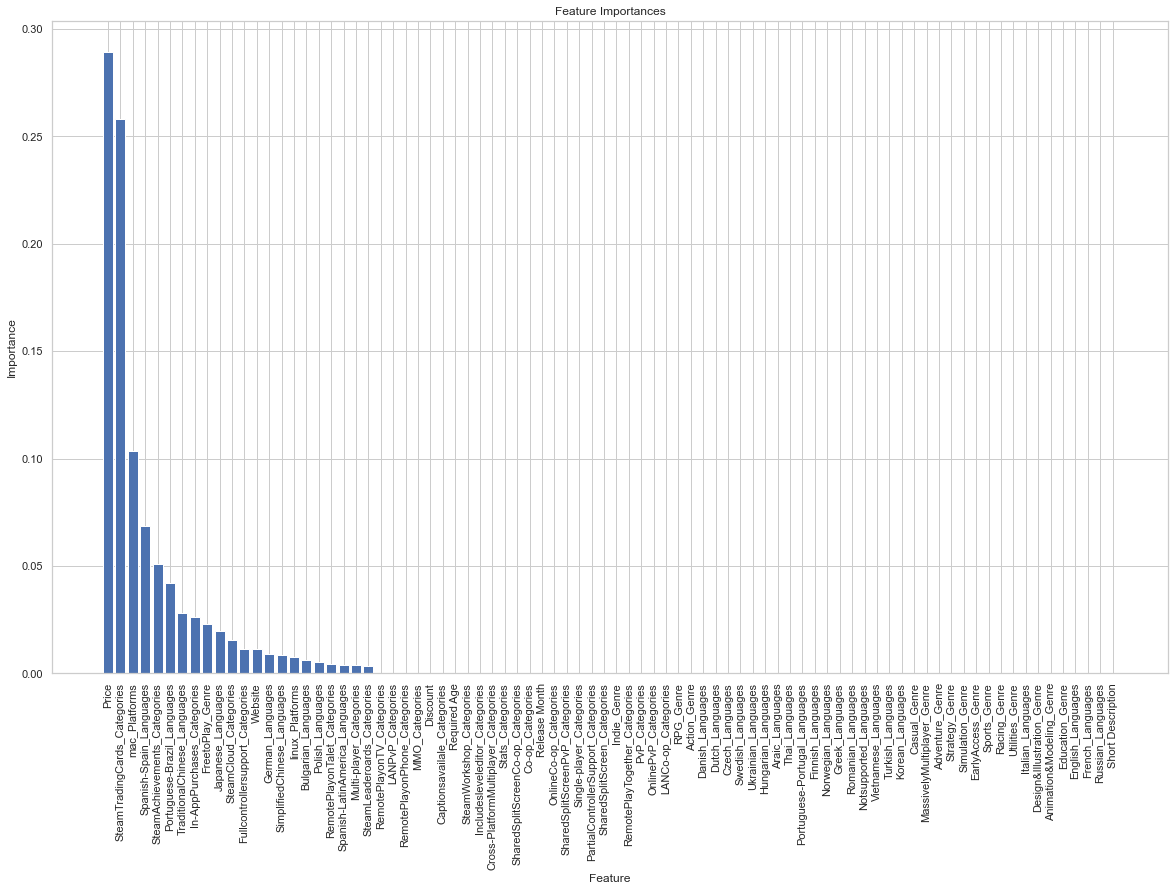

In [ ]:
# Extract the feature importances
importances = models['dt'].feature_importances_
features = list(X_train.columns)

# Sort the features by importance score
indices = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in indices]

# Plot the feature importances
plt.figure(figsize = (20,12))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), sorted_features, rotation=90)
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

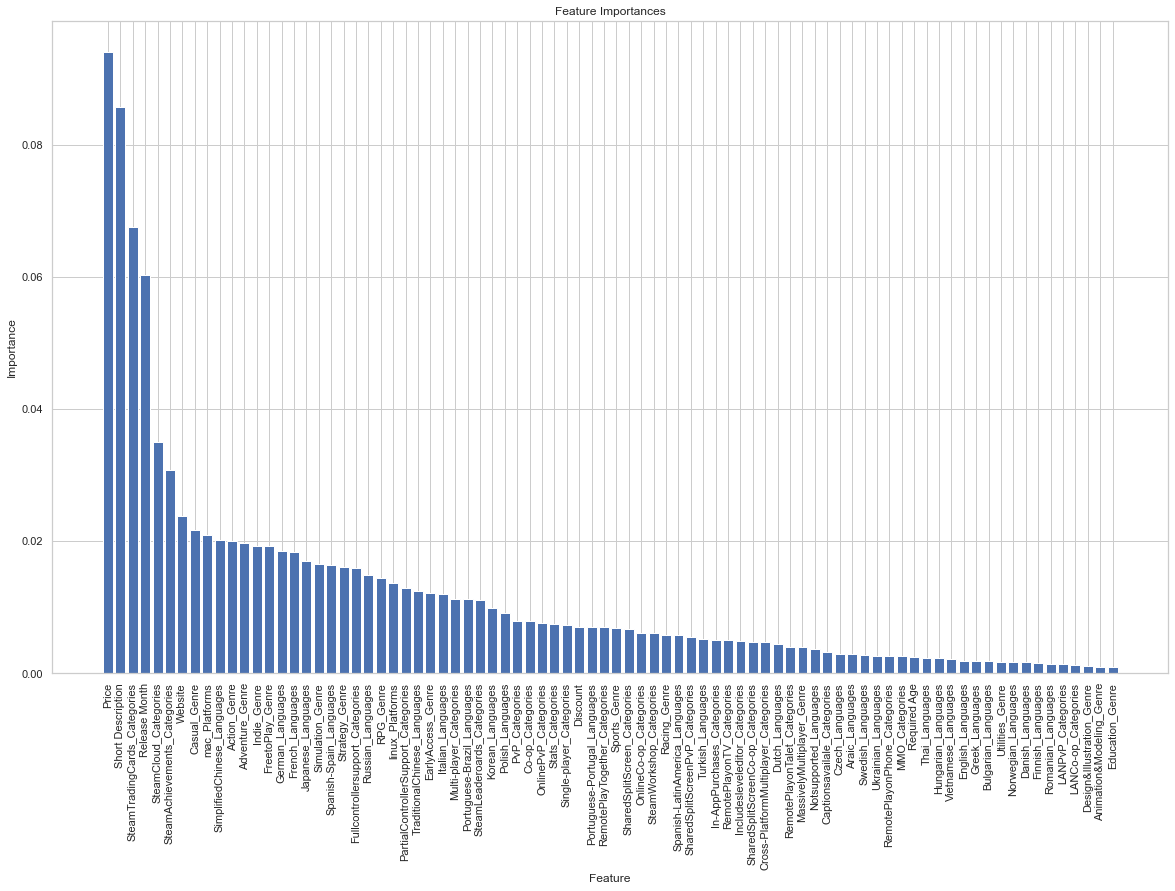

In [ ]:
# Extract the feature importance scores
importances = models['rf'].feature_importances_
features = list(X_train.columns)

# Sort the features by importance score
indices = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in indices]

# Plot the feature importances
plt.figure(figsize = (20,12))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), sorted_features, rotation=90)
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

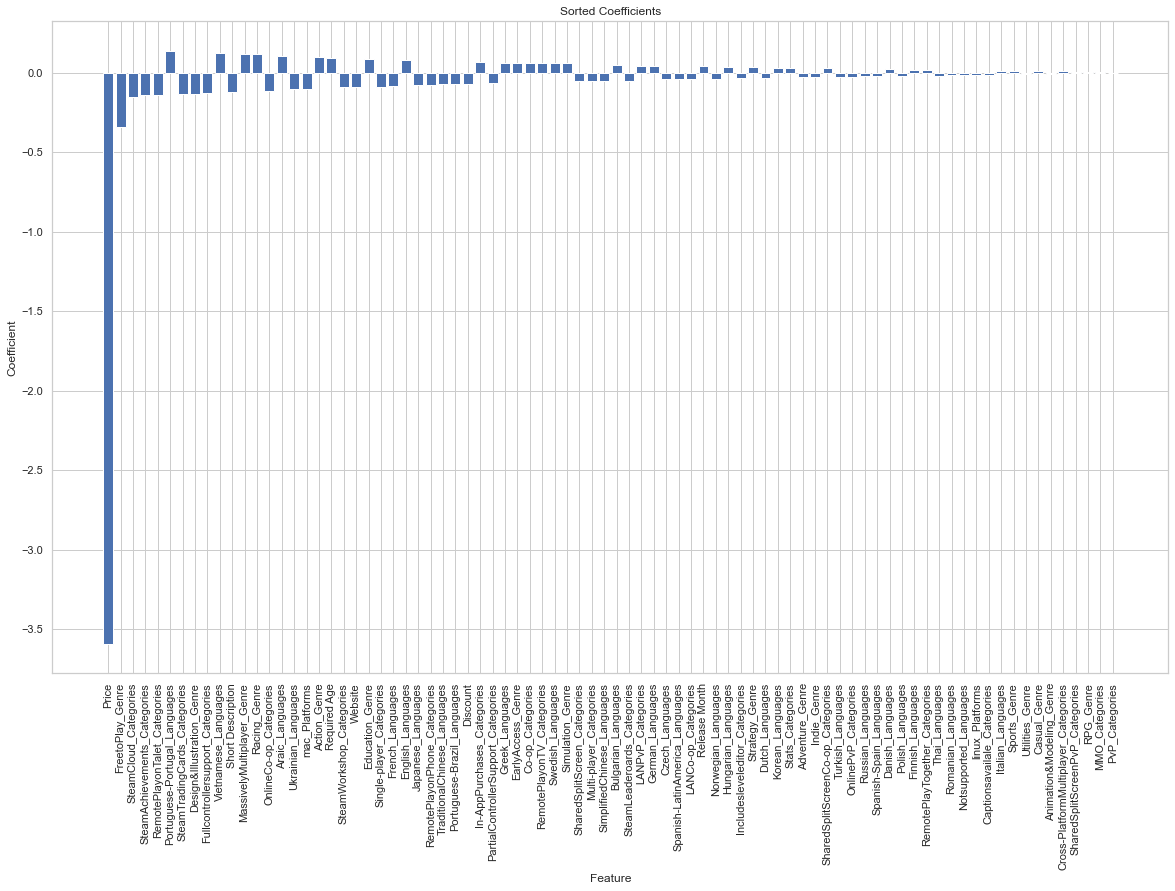

In [ ]:
# Get coefficients
coefficients = models['svm'].coef_

# Create a list of (column name, coefficient) tuples
coef_tuples = list(zip(X_train.columns.values, coefficients[0]))

# Sort the list by coefficient value in descending order
sorted_coefs = sorted(coef_tuples, key=lambda x: abs(x[1]), reverse=True)

# Extract the sorted column names and coefficients
sorted_names = [x[0] for x in sorted_coefs]
sorted_coefs = [x[1] for x in sorted_coefs]

# Plot the sorted coefficients
plt.figure(figsize=(20, 12))
plt.bar(range(len(sorted_coefs)), sorted_coefs)
plt.xticks(range(len(sorted_coefs)), sorted_names, rotation='vertical')
plt.title('Sorted Coefficients')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.show()

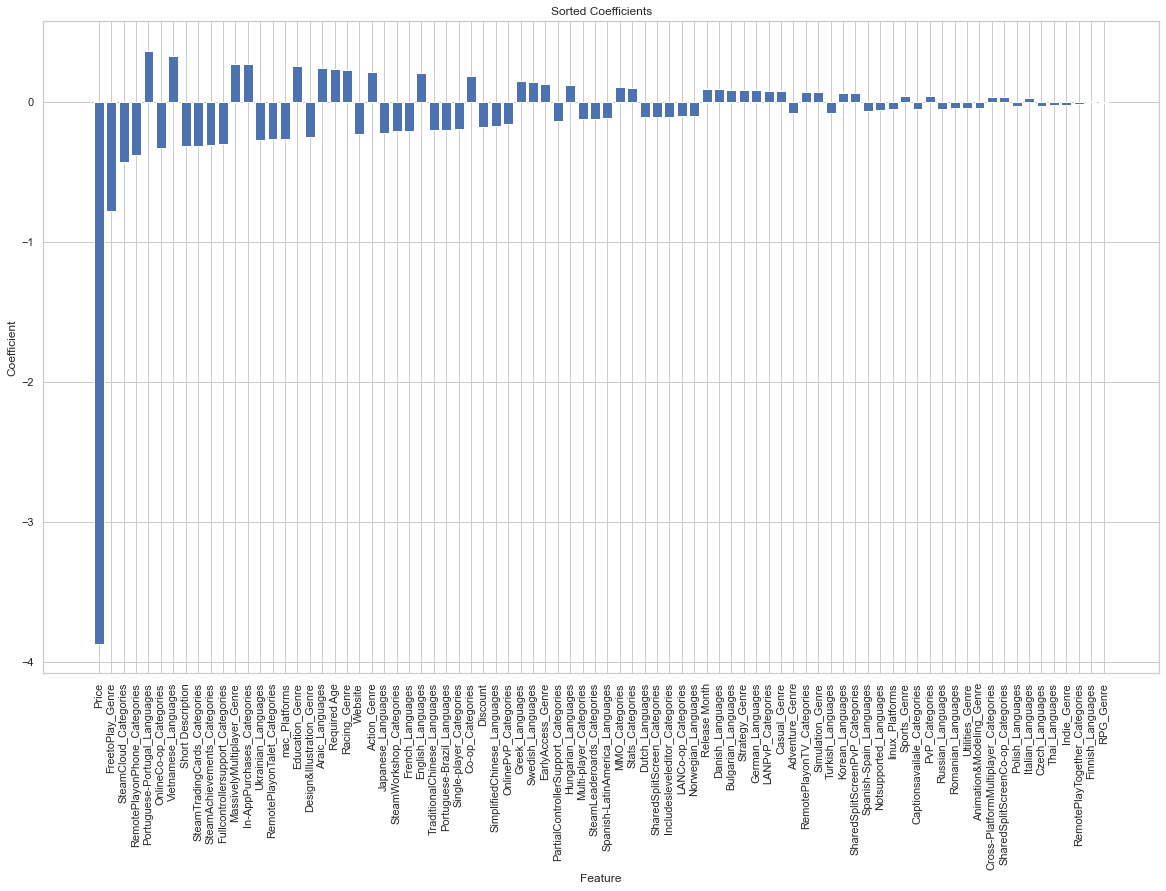

In [ ]:
# Get coefficients
coefficients = models['lr'].coef_

# Create a list of (column name, coefficient) tuples
coef_tuples = list(zip(X_train.columns.values, coefficients[0]))

# Sort the list by coefficient value in descending order
sorted_coefs = sorted(coef_tuples, key=lambda x: abs(x[1]), reverse=True)

# Extract the sorted column names and coefficients
sorted_names = [x[0] for x in sorted_coefs]
sorted_coefs = [x[1] for x in sorted_coefs]

# Plot the sorted coefficients
plt.figure(figsize=(20, 12))
plt.bar(range(len(sorted_coefs)), sorted_coefs)
plt.xticks(range(len(sorted_coefs)), sorted_names, rotation='vertical')
plt.title('Sorted Coefficients')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.show()

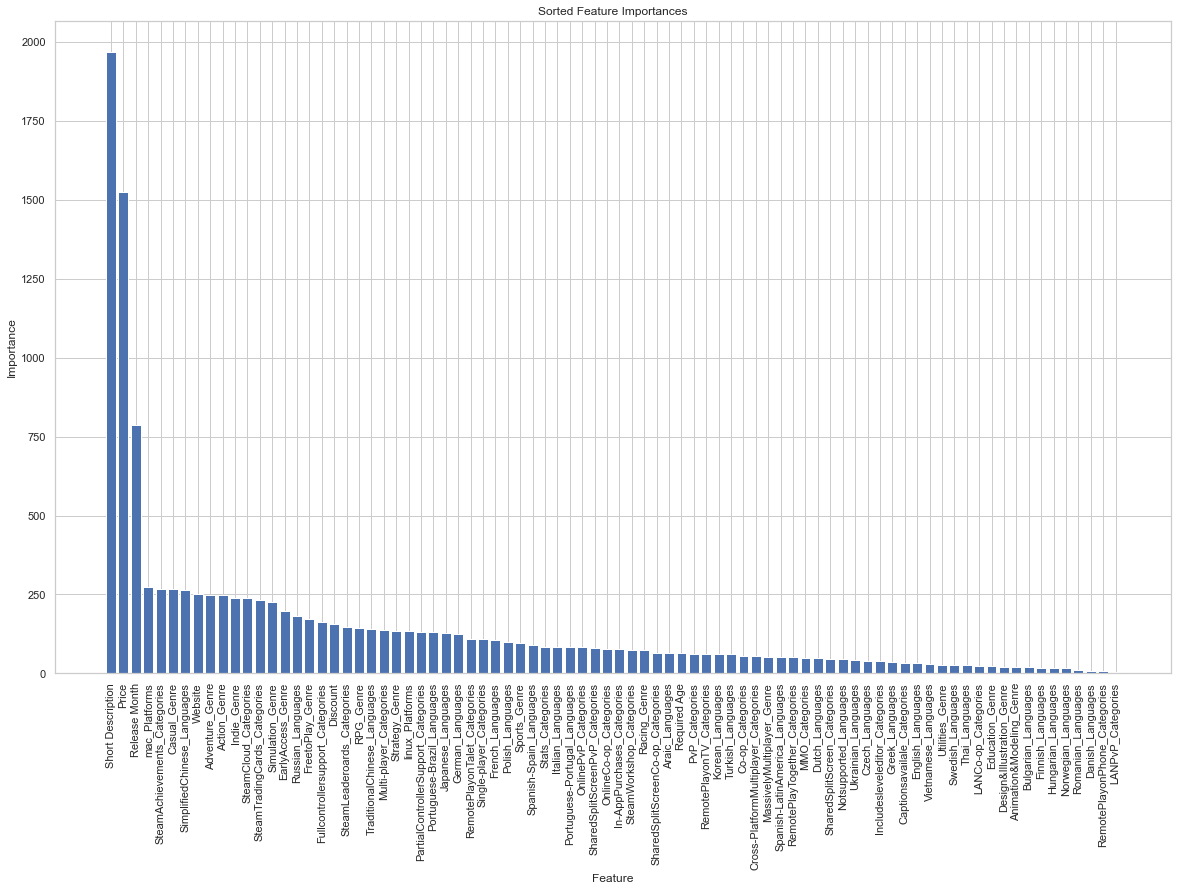

In [ ]:
# Get feature importances
importances = models['lgbm'].feature_importances_

# Create a list of (column name, importance) tuples
imp_tuples = list(zip(X_train.columns.values, importances))

# Sort the list by importance value in descending order
sorted_imps = sorted(imp_tuples, key=lambda x: x[1], reverse=True)

# Extract the sorted column names and importances
sorted_names = [x[0] for x in sorted_imps]
sorted_imps = [x[1] for x in sorted_imps]

# Plot the sorted feature importances
plt.figure(figsize=(20, 12))
plt.bar(range(len(sorted_imps)), sorted_imps)
plt.xticks(range(len(sorted_imps)), sorted_names, rotation='vertical')
plt.title('Sorted Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

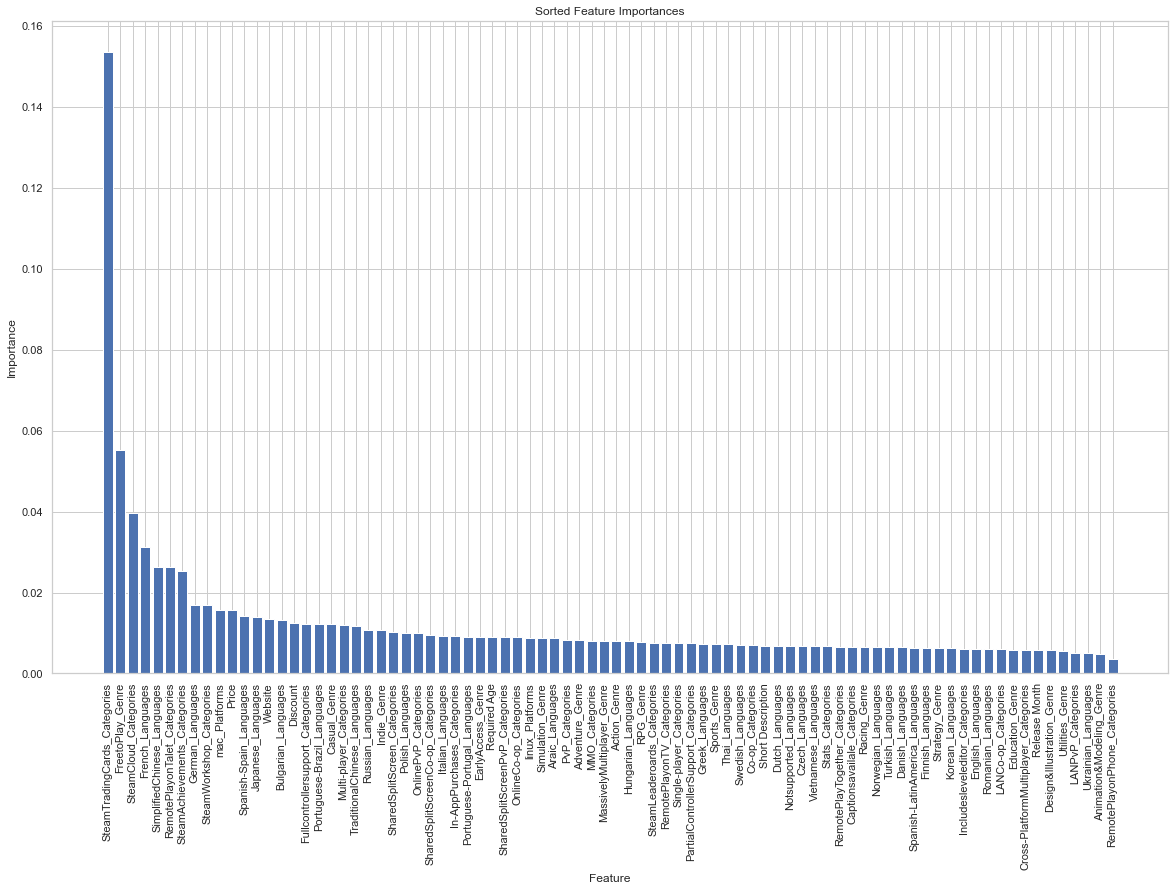

In [ ]:
# Get feature importances
importances = models['xgboost'].feature_importances_

# Create a list of (column name, importance) tuples
imp_tuples = list(zip(X_train.columns.values, importances))

# Sort the list by importance value in descending order
sorted_imps = sorted(imp_tuples, key=lambda x: x[1], reverse=True)

# Extract the sorted column names and importances
sorted_names = [x[0] for x in sorted_imps]
sorted_imps = [x[1] for x in sorted_imps]

# Plot the sorted feature importances
plt.figure(figsize=(20, 12))
plt.bar(range(len(sorted_imps)), sorted_imps)
plt.xticks(range(len(sorted_imps)), sorted_names, rotation='vertical')
plt.title('Sorted Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

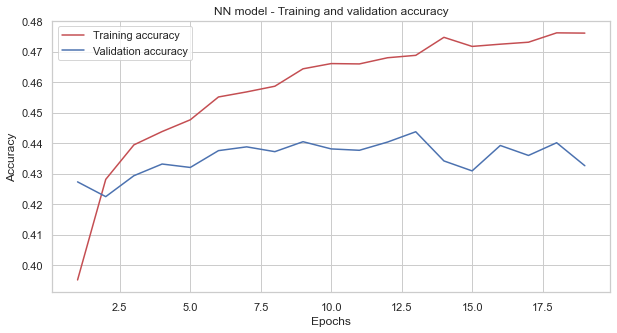

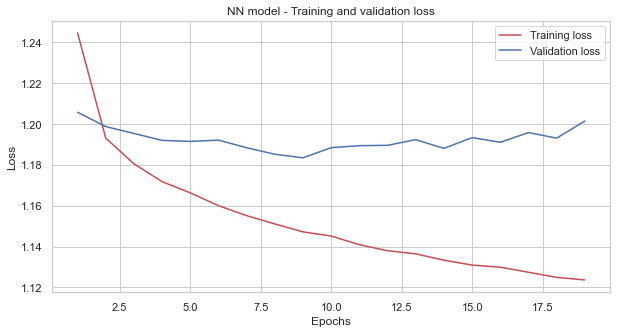

In [ ]:
# NN model - evaluation

models['nn'].plot()

<AxesSubplot:xlabel='Model'>

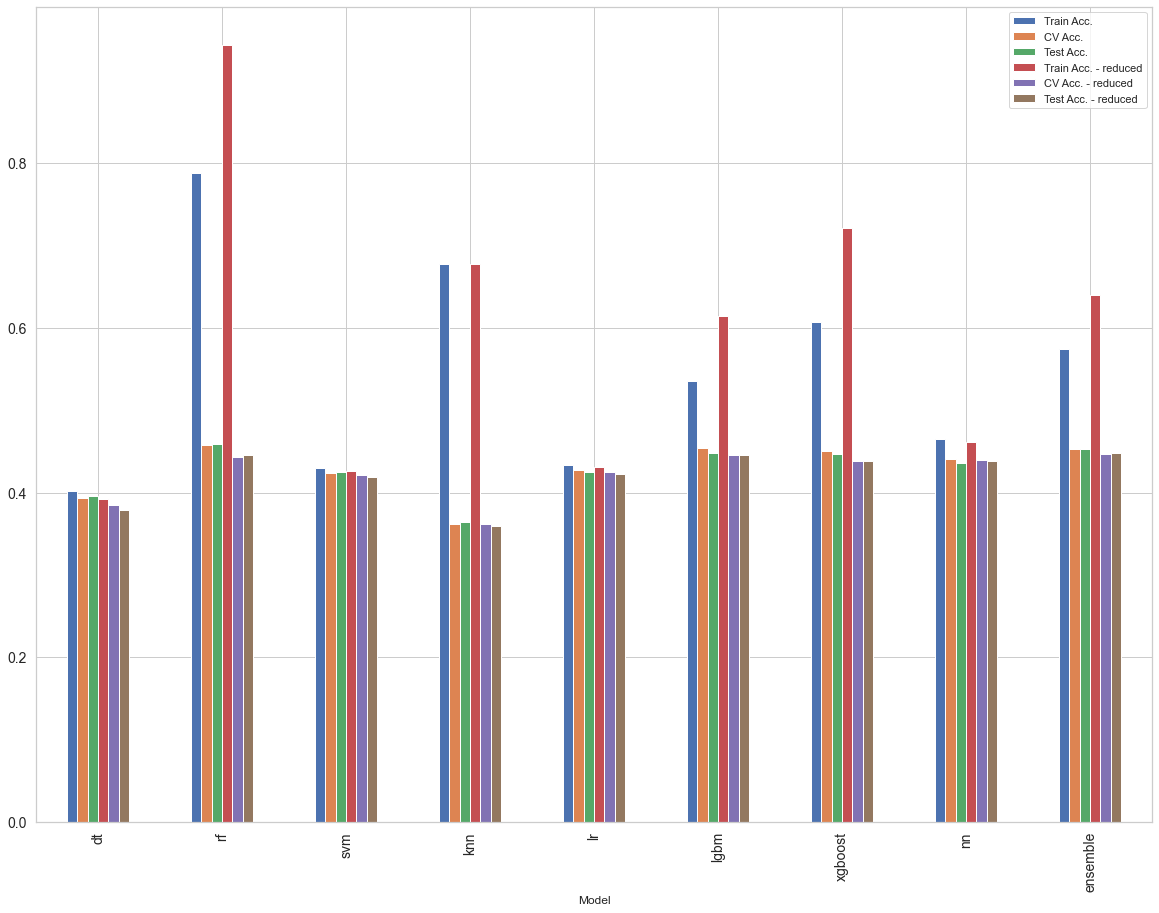

In [ ]:
# Accuracy comparison between models

acc_df = pd.DataFrame(list(zip(model_names, 
                               train_acc_list, validation_acc_list, test_acc_list, 
                               train_acc_reduced_list, validation_acc_reduced_list, test_acc_reduced_list)),
               columns =['Model', 
                         'Train Acc.', 'CV Acc.', 'Test Acc.', 
                         'Train Acc. - reduced', 'CV Acc. - reduced', 'Test Acc. - reduced'])
acc_df.plot(
    x="Model", y=['Train Acc.', 'CV Acc.', 'Test Acc.', 
                  'Train Acc. - reduced', 'CV Acc. - reduced', 'Test Acc. - reduced'], kind="bar", figsize=(20,15), fontsize=14
)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


<AxesSubplot:>

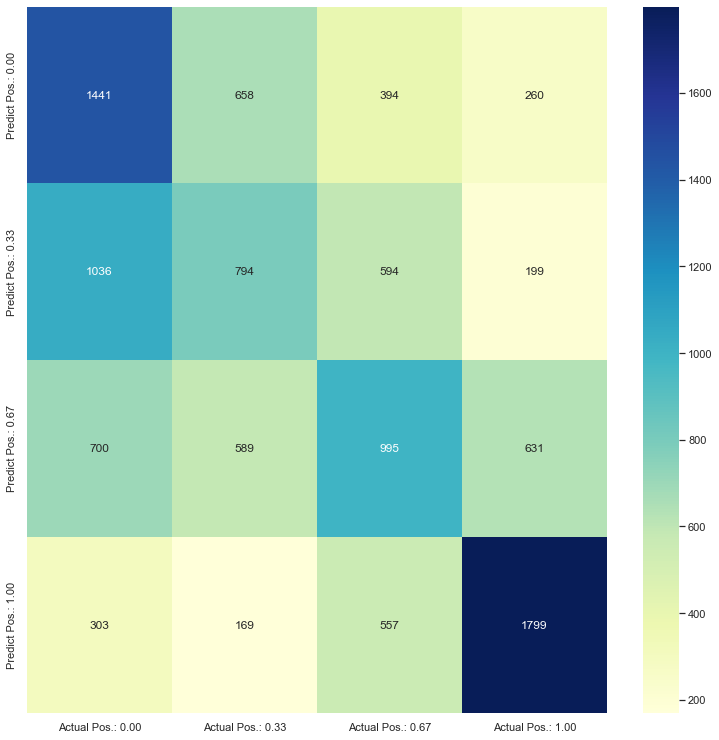

In [ ]:
# Confusion-matrix

cm = confusion_matrix(y_test, y_pred_test)
cm_matrix = pd.DataFrame(data=cm, columns=["Actual Pos.: " + str(class_name) for class_name in class_name_list], 
                                 index=["Predict Pos.: " + str(class_name) for class_name in class_name_list])

plt.figure(figsize = (13,13))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# Classification Metrices

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.41      0.52      0.46      2753
           1       0.36      0.30      0.33      2623
           2       0.39      0.34      0.36      2915
           3       0.62      0.64      0.63      2828

    accuracy                           0.45     11119
   macro avg       0.45      0.45      0.45     11119
weighted avg       0.45      0.45      0.45     11119



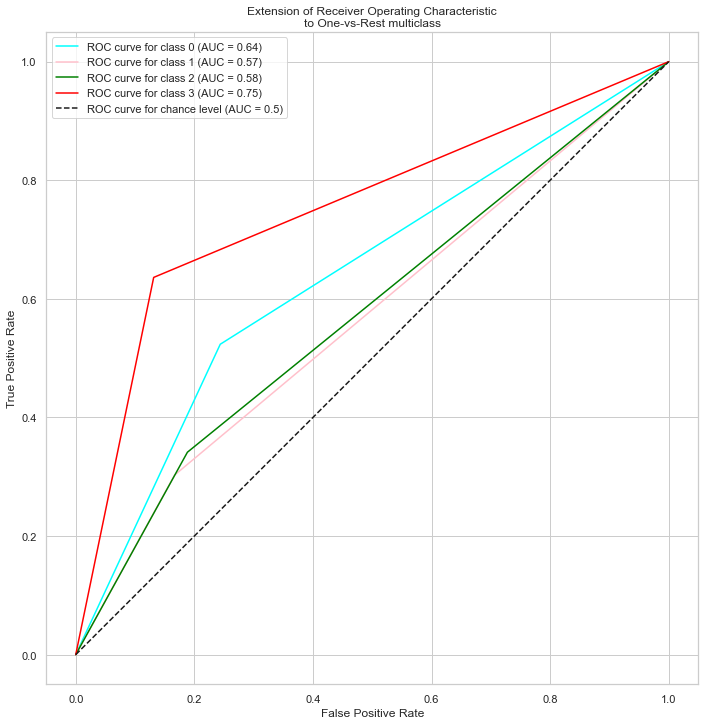

In [ ]:
# ROC - One-vs-Rest

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_pred_test = label_binarizer.transform(y_pred_test)
y_onehot_test.shape

fig, ax = plt.subplots(figsize=(12, 12))
colors = cycle(["aqua", "pink", "green", "red"])
for class_id, color in zip(range(0, len(class_name_list)), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_onehot_pred_test[:, class_id],
        name=f"ROC curve for class {class_id}",
        color=color,
        ax=ax,
    )
    
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

<AxesSubplot:xlabel='Model'>

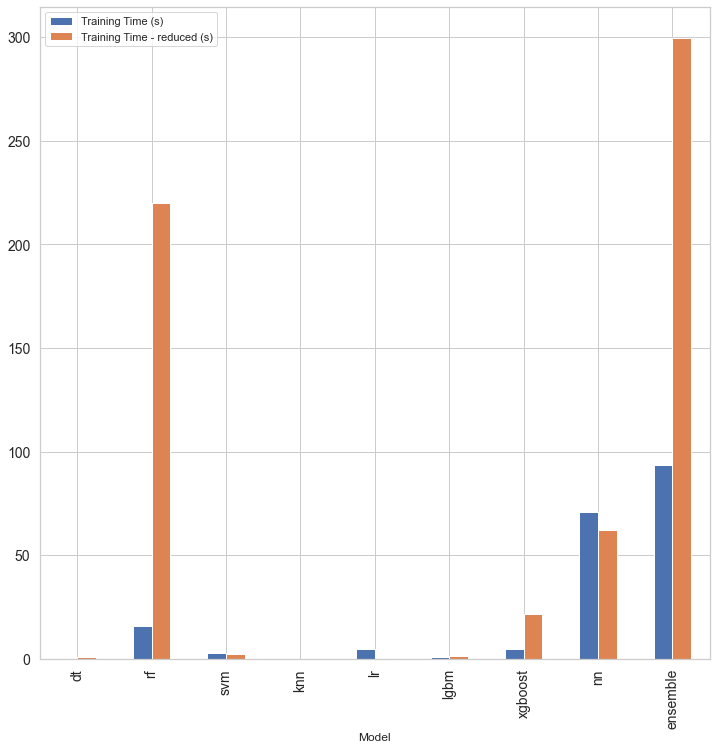

In [ ]:
# Comparison in model training process time between higher and lower dimension after PCA - TODO - WHY???

time_df = pd.DataFrame(list(zip(model_names, 
                               training_time, training_reduced_time)),
               columns =['Model', 
                         'Training Time (s)', 
                         'Training Time - reduced (s)'])
time_df.plot(
    x="Model", 
    y=['Training Time (s)', 'Training Time - reduced (s)'], 
    kind="bar", figsize=(12,12), fontsize=14
)

<AxesSubplot:xlabel='Model'>

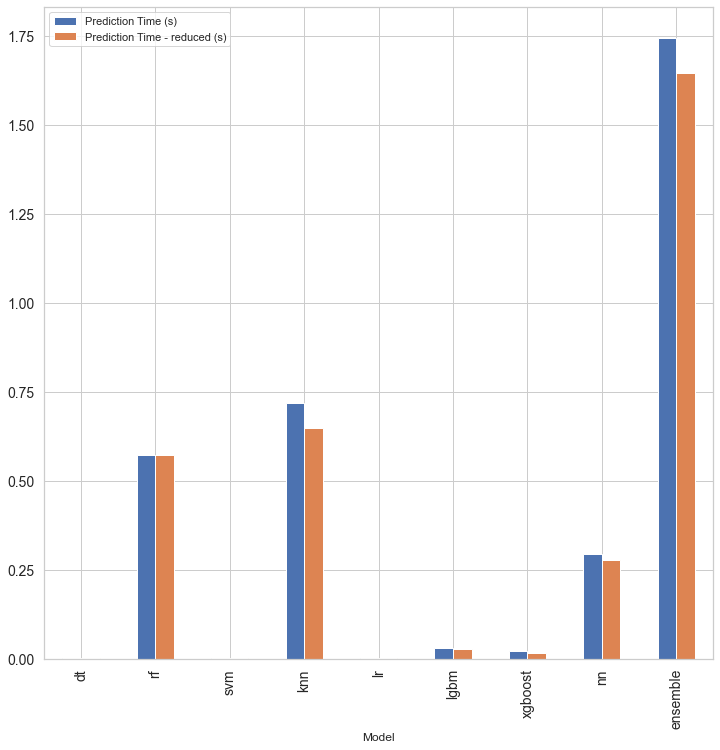

In [ ]:
# Comparison in model prediction process time between higher and lower dimension after PCA

time_df = pd.DataFrame(list(zip(model_names, 
                               prediction_time, prediction_reduced_time)),
               columns =['Model', 
                         'Prediction Time (s)', 
                         'Prediction Time - reduced (s)'])
time_df.plot(
    x="Model", 
    y=['Prediction Time (s)', 'Prediction Time - reduced (s)'], 
    kind="bar", figsize=(12,12), fontsize=14
)